## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
img_shape = None
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_shape = img.shape
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

        
# Now we calculate distrotion coffecients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_shape[0],img_shape[1]),None,None)

## Next define undistort function and run on the test images

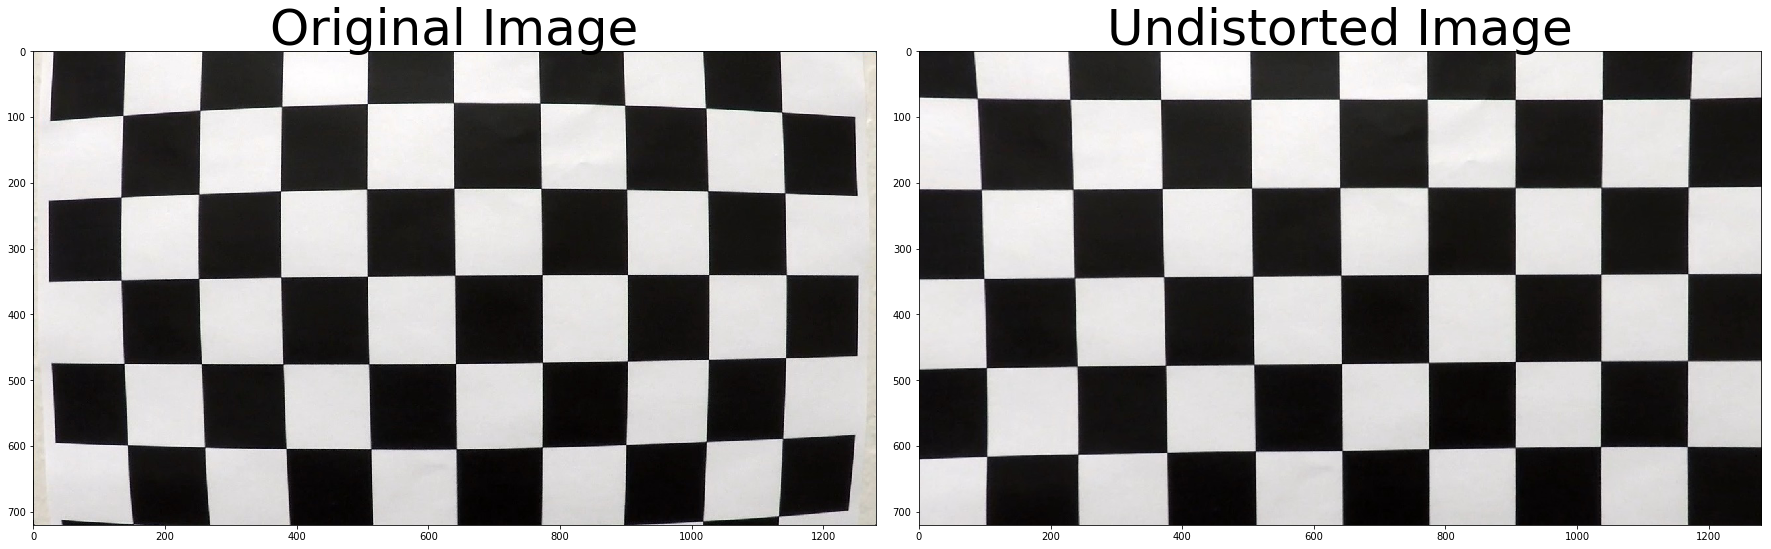

In [2]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst 

#Testing undistortion function on test image
test_img =  mpimg.imread('camera_cal/calibration1.jpg')
undistorted = undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

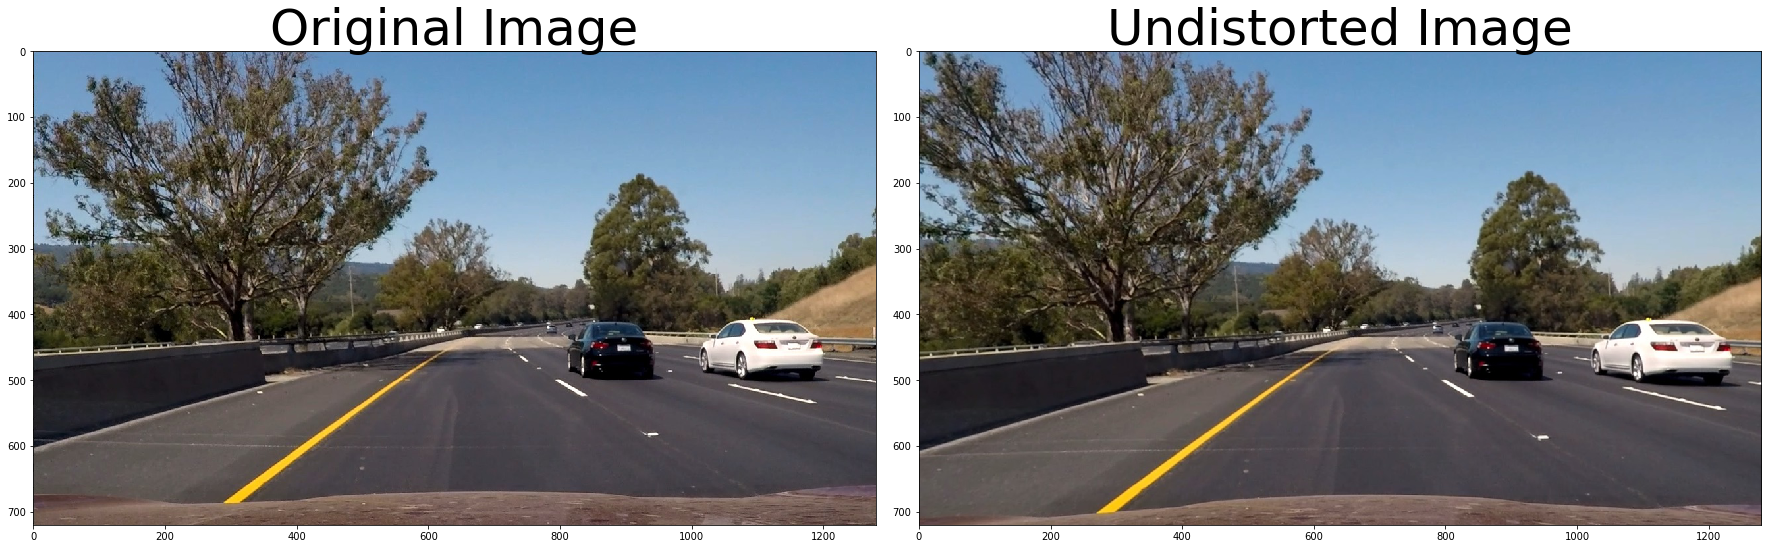

In [3]:
test_img =  mpimg.imread('camera_cal/test6.jpg')
undistorted = undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def hls_select_h(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output


def hls_select_l(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output


def hls_select_s(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def apply_perspectivetransform(img,reverse = False):
    img_size = (img.shape[1], img.shape[0])
    image_width = img.shape[1]
    image_height = img.shape[0]
    
    src = np.float32([
            [image_width * 0.4475, image_height * 0.65],
            [image_width * 0.5525, image_height * 0.65],
            [image_width * 0.175, image_height * 0.95],
            [image_width * 0.825, image_height * 0.95],
        ])
    
    # Destination coordinates
    dst = np.float32([
            [image_width * 0.2, image_height * 0.025],
            [image_width * 0.8, image_height * 0.025],
            [image_width * 0.2, image_height * 0.980],
            [image_width * 0.8, image_height * 0.980],
        ])
    
    if(reverse):
        src, dst = dst, src
        
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [5]:
left_fit = None
right_fit = None
prev_left_x_pts = None
prev_left_y_pts = None
prev_right_x_pts = None 
prev_right_y_pts = None

In [6]:
def get_warped_img(img):
    image = undistort(img)
    ksize =15
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    s_thresh=(170, 255)
    sx_thresh=(40, 170)
    
    # Gradients channels
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=sx_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(40, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
     
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    plt.imshow(combined_binary)
    warped = apply_perspectivetransform(combined_binary)
    return warped    

def get_fitted_line(binary_warped):
        global left_fit 
        global right_fit
        global prev_left_x_pts 
        global prev_left_y_pts 
        global prev_right_x_pts 
        global prev_right_y_pts  
        if(left_fit != None and right_fit != None):
            print("old")
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            combined_leftx = np.append(leftx ,prev_left_x_pts)
            combined_lefty = np.append(lefty ,prev_left_y_pts)
            combined_rightx = np.append(rightx, prev_right_x_pts)
            combined_righty = np.append(righty ,prev_right_y_pts)
            
            prev_left_x_pts = leftx
            prev_left_y_pts = lefty
            prev_right_x_pts = rightx
            prev_right_y_pts = righty
            
            # Fit a second order polynomial to each
            left_fit = np.polyfit(combined_lefty, combined_leftx, 2)
            right_fit = np.polyfit(combined_righty, combined_rightx, 2)
            return left_fit,right_fit , left_lane_inds, right_lane_inds
        else:
            print("new")
            
            histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,255), 5) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,255,255), 5)
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))



                # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

                # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 
            
            prev_left_x_pts = leftx
            prev_left_y_pts = lefty
            prev_right_x_pts = rightx
            prev_right_y_pts = righty
            
                # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            return left_fit,right_fit , left_lane_inds, right_lane_inds
        
def draw_fitted_line_over_warped_image(binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

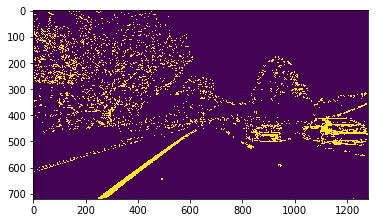

In [16]:
warped_test = get_warped_img(undistorted)

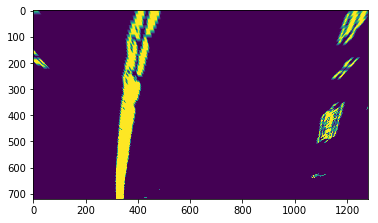

In [17]:
plt.imshow(warped_test)

/home/sahil/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


old
<class 'numpy.ndarray'>


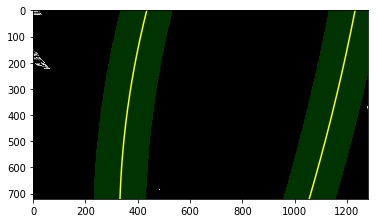

In [21]:
left_fit_test , right_fit_test , left_lane_inds_test ,right_lane_inds_test = get_fitted_line(warped_test)
draw_fitted_line_over_warped_image(warped_test,left_fit_test , right_fit_test , left_lane_inds_test ,right_lane_inds_test)

In [7]:
# Evaluates polynomial and finds value at given point
def get_x_for_line(line_fit, line_y):
    poly = np.poly1d(line_fit)
    return poly(line_y)

def draw_lane_lines_to_original_image(binary_warped,undistorted_image,left_fit,right_fit,left_lane_inds,right_lane_inds,image_width,image_height):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    margin = 100

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    y_eval = np.max(ploty)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix,right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    left_fitx_bottom_m = get_x_for_line(left_fit_cr, image_height * ym_per_pix)
    right_fitx_bottom_m = get_x_for_line(right_fit_cr, image_height * ym_per_pix)
    
    # Calculate image center, in meters
    center_ideal_m = image_width* xm_per_pix / 2
    # Calculate actual center of the lane, in meters
    center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])
    
    # Calculate distance from center, in meters
    distance_from_center = abs(center_ideal_m - center_actual_m)
    print(distance_from_center)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = apply_perspectivetransform(color_warp, reverse = True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    
    #Add curvature information 
    text_offset = 100
    text_shift = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Left Curvature: ' + str(left_curverad)
    cv2.putText(result, text, \
                (text_offset + text_shift, image_height - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    
    text_offset = text_offset -30
    
    text = 'Right Curvature: ' + str(right_curverad)
    cv2.putText(result, text, \
                (text_offset + text_shift, image_height - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    
    text_offset = text_offset -30
    text = 'Center offset :  ' + str(distance_from_center)
    cv2.putText(result, text, \
                (text_offset + text_shift, image_height - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    
    return result

def process_image(img):
    # Undistort given image
    undistorted_image = undistort(img)
    
    image_width = img.shape[1]
    image_height =  img.shape[0]
    
    binary_warped = get_warped_img(undistorted_image)
    
    left_fit,right_fit , left_lane_inds, right_lane_inds = get_fitted_line(binary_warped)
    
    return draw_lane_lines_to_original_image(binary_warped,undistorted_image,left_fit,right_fit,left_lane_inds,right_lane_inds,image_width,image_height)


1078.80738533 m 2475.05359561 m
0.286009449629


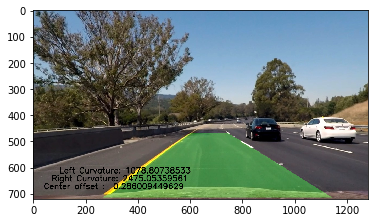

In [20]:
plt.imshow(draw_lane_lines_to_original_image(warped_test,undistorted,left_fit_test , right_fit_test , left_lane_inds_test ,right_lane_inds_test,undistorted.shape[1],undistorted.shape[0]))

In [8]:
left_fit = None
right_fit = None
prev_left_x_pts = None
prev_left_y_pts = None
prev_right_x_pts = None 
prev_right_y_pts = None

In [ ]:
from moviepy.editor import VideoFileClip
white_output = 'output_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

new
1234.93424077 m 413.852015947 m
0.578537173448
[MoviePy] >>>> Building video output_final.mp4
[MoviePy] Writing video output_final.mp4


  0%|          | 1/1261 [00:00<13:31,  1.55it/s]

old
1215.84285562 m 410.966892492 m
0.57798223387


  0%|          | 2/1261 [00:01<12:49,  1.64it/s]

old
1040.23353501 m 445.231729189 m
0.544604150159


  0%|          | 3/1261 [00:01<12:17,  1.70it/s]

old
862.736088607 m 1652.94152465 m
0.458828182978


  0%|          | 4/1261 [00:02<11:50,  1.77it/s]

old
793.227820751 m 1064.10777196 m
0.415645359135


  0%|          | 5/1261 [00:02<11:36,  1.80it/s]

old
762.021002644 m 1138.19947939 m
0.421373209561


  0%|          | 6/1261 [00:03<11:25,  1.83it/s]

old
793.318016582 m 847.232997705 m
0.421224613767


  1%|          | 7/1261 [00:03<11:16,  1.85it/s]

old
854.976978501 m 496.214595436 m
0.413230957656


  1%|          | 8/1261 [00:04<11:07,  1.88it/s]

old
902.585606286 m 409.358491239 m
0.396280405568


  1%|          | 9/1261 [00:04<11:02,  1.89it/s]

old
982.001005155 m 357.426741216 m
0.357088601744


  1%|          | 10/1261 [00:05<11:05,  1.88it/s]

old
1000.06507329 m 566.386970659 m
0.431298391689


  1%|          | 11/1261 [00:05<11:04,  1.88it/s]

old
925.023610841 m 7164.52417975 m
0.521060985578


  1%|          | 12/1261 [00:06<10:59,  1.89it/s]

old
879.352914721 m 1134.01968437 m
0.558734404622


  1%|          | 13/1261 [00:06<11:00,  1.89it/s]

old
855.352338284 m 611.472727333 m
0.578835175734


  1%|          | 14/1261 [00:07<11:02,  1.88it/s]

old
854.033737179 m 391.765659185 m
0.591960787628


  1%|          | 15/1261 [00:08<10:59,  1.89it/s]

old
939.911616496 m 575.645186346 m
0.523630669312


  1%|▏         | 16/1261 [00:08<10:56,  1.90it/s]

old
902.156524407 m 5112.04919647 m
0.440791794164


  1%|▏         | 17/1261 [00:09<11:00,  1.88it/s]

old
913.298540613 m 3079.7555449 m
0.428901850799


  1%|▏         | 18/1261 [00:09<11:01,  1.88it/s]

old
1102.92984576 m 1259.52439716 m
0.420454081429


  2%|▏         | 19/1261 [00:10<10:55,  1.89it/s]

old
1306.76353887 m 648.66489232 m
0.40397912007


  2%|▏         | 20/1261 [00:10<10:50,  1.91it/s]

old
1433.86304369 m 515.232124478 m
0.386054890312


  2%|▏         | 21/1261 [00:11<10:48,  1.91it/s]

old
1580.50750993 m 380.135656931 m
0.325637079969


  2%|▏         | 22/1261 [00:11<10:53,  1.90it/s]

old
1670.44809177 m 300.892236884 m
0.258360726689


  2%|▏         | 23/1261 [00:12<10:53,  1.89it/s]

old
1452.33935957 m 399.677298146 m
0.316227129076


  2%|▏         | 24/1261 [00:12<10:52,  1.89it/s]

old
1304.12530337 m 881.627099987 m
0.391021134038


  2%|▏         | 25/1261 [00:13<10:55,  1.89it/s]

old
1228.53526058 m 2447.55931067 m
0.455923709692


  2%|▏         | 26/1261 [00:13<10:56,  1.88it/s]

old
1269.96014734 m 685.549916869 m
0.486837968439


  2%|▏         | 27/1261 [00:14<10:58,  1.88it/s]

old
1285.66970557 m 514.676360537 m
0.485531161923


  2%|▏         | 28/1261 [00:14<10:56,  1.88it/s]

old
1193.15815083 m 551.56438709 m
0.450412663799


  2%|▏         | 29/1261 [00:15<10:53,  1.89it/s]

old
1066.35818205 m 1481.77164664 m
0.393517459458


  2%|▏         | 30/1261 [00:15<10:53,  1.88it/s]

old
950.652860995 m 1313.30255449 m
0.354564979602


  2%|▏         | 31/1261 [00:16<10:53,  1.88it/s]

old
883.711676134 m 1542.54657639 m
0.356216864642


  3%|▎         | 32/1261 [00:17<10:53,  1.88it/s]

old
887.990460604 m 956.198563762 m
0.350671798007


  3%|▎         | 33/1261 [00:17<10:50,  1.89it/s]

old
901.816333156 m 443.210362778 m
0.31740462983


  3%|▎         | 34/1261 [00:18<10:48,  1.89it/s]

old
881.900413026 m 310.404870084 m
0.244838900439


  3%|▎         | 35/1261 [00:18<10:49,  1.89it/s]

old
827.195742297 m 406.662480738 m
0.302650799386


  3%|▎         | 36/1261 [00:19<10:50,  1.88it/s]

old
733.355730556 m 1683.78659397 m
0.420013372422


  3%|▎         | 37/1261 [00:19<10:50,  1.88it/s]

old
712.422039829 m 1088.60640557 m
0.488307629361


  3%|▎         | 38/1261 [00:20<10:47,  1.89it/s]

old
733.547132191 m 503.494049232 m
0.527026425082


  3%|▎         | 39/1261 [00:20<10:48,  1.89it/s]

old
680.78936508 m 625.345220008 m
0.481434600389


  3%|▎         | 40/1261 [00:21<10:46,  1.89it/s]

old
630.098966509 m 18619.6977508 m
0.394007664725


  3%|▎         | 41/1261 [00:21<10:44,  1.89it/s]

old
597.364413627 m 1297.79918479 m
0.367597299239


  3%|▎         | 42/1261 [00:22<10:44,  1.89it/s]

old
615.5327662 m 1277.42288726 m
0.373019932015


  3%|▎         | 43/1261 [00:22<10:55,  1.86it/s]

old
671.489999619 m 1198.63876451 m
0.381354120848


  3%|▎         | 44/1261 [00:23<10:51,  1.87it/s]

old
699.639911688 m 843.542703689 m
0.380441769956


  4%|▎         | 45/1261 [00:23<10:46,  1.88it/s]

old
738.197980967 m 547.531466985 m
0.371066016966


  4%|▎         | 46/1261 [00:24<10:45,  1.88it/s]

old
797.87788701 m 362.05621033 m
0.329253452685


  4%|▎         | 47/1261 [00:24<10:42,  1.89it/s]

old
844.769702024 m 274.457981214 m
0.251146471313


  4%|▍         | 48/1261 [00:25<10:41,  1.89it/s]

old
774.614064934 m 433.619793203 m
0.351458840826


  4%|▍         | 49/1261 [00:26<10:40,  1.89it/s]

old
743.449769747 m 1071.0694078 m
0.432650109876


  4%|▍         | 50/1261 [00:26<10:50,  1.86it/s]

old
749.041554882 m 4956.82163738 m
0.484059188774


  4%|▍         | 51/1261 [00:27<10:45,  1.87it/s]

old
715.872447092 m 644.378104413 m
0.532639172119


  4%|▍         | 52/1261 [00:27<10:42,  1.88it/s]

old
701.403010083 m 479.329663641 m
0.526413838434


  4%|▍         | 53/1261 [00:28<10:38,  1.89it/s]

old
751.786206078 m 1533.01499664 m
0.444845163599


  4%|▍         | 54/1261 [00:28<10:38,  1.89it/s]

old
886.457062944 m 1321.29988011 m
0.395437363948


  4%|▍         | 55/1261 [00:29<10:35,  1.90it/s]

old
1044.49824542 m 1121.57900903 m
0.394563213792


  4%|▍         | 56/1261 [00:29<10:35,  1.90it/s]

old
1196.73951913 m 1595.47753 m
0.400376065449


  5%|▍         | 57/1261 [00:30<10:35,  1.89it/s]

old
1391.54590564 m 859.388710102 m
0.390629459623


  5%|▍         | 58/1261 [00:30<10:35,  1.89it/s]

old
1498.79144492 m 419.832460814 m
0.355131817871


  5%|▍         | 59/1261 [00:31<10:34,  1.90it/s]

old
1260.42022196 m 312.733336688 m
0.281412655951


  5%|▍         | 60/1261 [00:31<10:37,  1.88it/s]

old
1179.28031099 m 620.883699982 m
0.374631966777


  5%|▍         | 61/1261 [00:32<10:39,  1.88it/s]

old
1306.19827678 m 1936.78443428 m
0.487782059682


  5%|▍         | 62/1261 [00:32<10:39,  1.87it/s]

old
1289.59036731 m 718.457408285 m
0.499678661036


  5%|▍         | 63/1261 [00:33<10:37,  1.88it/s]

old
1148.74039166 m 746.049109785 m
0.466182272731


  5%|▌         | 64/1261 [00:33<10:32,  1.89it/s]

old
1032.28551017 m 2431.19179502 m
0.400798068421


  5%|▌         | 65/1261 [00:34<10:34,  1.88it/s]

old
932.101517002 m 2252.13953734 m
0.347893640153


  5%|▌         | 66/1261 [00:35<10:33,  1.89it/s]

old
887.795797612 m 2408.63438917 m
0.332740308812


  5%|▌         | 67/1261 [00:35<10:31,  1.89it/s]

old
909.717165183 m 2746.13928951 m
0.321446690779


  5%|▌         | 68/1261 [00:36<10:33,  1.88it/s]

old
957.75486536 m 1213.93640804 m
0.305906274237


  5%|▌         | 69/1261 [00:36<10:35,  1.88it/s]

old
918.854485248 m 596.182125615 m
0.286863877333


  6%|▌         | 70/1261 [00:37<10:34,  1.88it/s]

old
851.626036644 m 493.278835429 m
0.266145759499


  6%|▌         | 71/1261 [00:37<10:34,  1.88it/s]

old
834.131551134 m 451.239711676 m
0.23312545242


  6%|▌         | 72/1261 [00:38<10:38,  1.86it/s]

old
814.129701038 m 516.656859124 m
0.235975807633


  6%|▌         | 73/1261 [00:38<10:32,  1.88it/s]

old
872.771862577 m 1371.0867615 m
0.312517426873


  6%|▌         | 74/1261 [00:39<10:33,  1.87it/s]

old
1043.71822327 m 2850.18721385 m
0.366195204395


  6%|▌         | 75/1261 [00:39<10:34,  1.87it/s]

old
1219.89070592 m 877.051992418 m
0.391317065177


  6%|▌         | 76/1261 [00:40<10:31,  1.88it/s]

old
1427.32428533 m 570.279999288 m
0.403510593703


  6%|▌         | 77/1261 [00:40<10:30,  1.88it/s]

old
1735.0078335 m 513.501809597 m
0.389540315388


  6%|▌         | 78/1261 [00:41<10:30,  1.88it/s]

old
2092.35542937 m 691.044518005 m
0.346939075142


  6%|▋         | 79/1261 [00:42<10:33,  1.86it/s]

old
2517.74466026 m 2222.72344097 m
0.298586466269


  6%|▋         | 80/1261 [00:42<10:30,  1.87it/s]

old
3309.64690508 m 1808.36574638 m
0.267554946765


  6%|▋         | 81/1261 [00:43<10:33,  1.86it/s]

old
4149.22533518 m 1267.65745414 m
0.258641764981


  7%|▋         | 82/1261 [00:43<10:29,  1.87it/s]

old
4473.90134763 m 840.529735494 m
0.244273115822


  7%|▋         | 83/1261 [00:44<10:32,  1.86it/s]

old
4013.43141604 m 486.937566234 m
0.213446627722


  7%|▋         | 84/1261 [00:44<10:29,  1.87it/s]

old
3567.81879421 m 340.347574011 m
0.14372374487


  7%|▋         | 85/1261 [00:45<10:23,  1.89it/s]

old
2968.30498228 m 299.22117925 m
0.109700057989


  7%|▋         | 86/1261 [00:45<10:21,  1.89it/s]

old
1986.8391716 m 438.81205692 m
0.182701977403


  7%|▋         | 87/1261 [00:46<10:25,  1.88it/s]

old
1591.3341681 m 1921.59005385 m
0.275605281383


  7%|▋         | 88/1261 [00:46<10:21,  1.89it/s]

old
1258.85122893 m 636.950062266 m
0.363864696538


  7%|▋         | 89/1261 [00:47<10:21,  1.89it/s]

old
1039.60993143 m 473.670783506 m
0.35628468789


  7%|▋         | 90/1261 [00:47<10:20,  1.89it/s]

old
939.929994818 m 1695.2431443 m
0.266331816258


  7%|▋         | 91/1261 [00:48<10:18,  1.89it/s]

old
859.631070498 m 1641.64527439 m
0.217399879568


  7%|▋         | 92/1261 [00:48<10:13,  1.91it/s]

old
829.824288989 m 1746.48843333 m
0.215282355355


  7%|▋         | 93/1261 [00:49<10:20,  1.88it/s]

old
877.294561479 m 1750.9644489 m
0.218860575497


  7%|▋         | 94/1261 [00:49<10:17,  1.89it/s]

old
894.940350913 m 708.626794122 m
0.209724885159


  8%|▊         | 95/1261 [00:50<10:15,  1.90it/s]

old
836.976050975 m 512.399557882 m
0.196800340887


  8%|▊         | 96/1261 [00:51<10:12,  1.90it/s]

old
782.935150242 m 455.561425642 m
0.171280068035


  8%|▊         | 97/1261 [00:51<10:13,  1.90it/s]

old
740.327474367 m 424.207892229 m
0.139083179591


  8%|▊         | 98/1261 [00:52<10:12,  1.90it/s]

old
751.499588896 m 846.347576842 m
0.224908317621


  8%|▊         | 99/1261 [00:52<10:11,  1.90it/s]

old
825.059260942 m 13887.3985358 m
0.289875779654


  8%|▊         | 100/1261 [00:53<10:14,  1.89it/s]

old
873.895605111 m 1138.29248398 m
0.329855285889


  8%|▊         | 101/1261 [00:53<10:15,  1.88it/s]

old
882.577672968 m 675.81934367 m
0.346399475601


  8%|▊         | 102/1261 [00:54<10:19,  1.87it/s]

old
929.027875547 m 661.296040978 m
0.32772093765


  8%|▊         | 103/1261 [00:54<10:16,  1.88it/s]

old
963.780908831 m 4513.76140014 m
0.265837421001


  8%|▊         | 104/1261 [00:55<10:19,  1.87it/s]

old
882.58799497 m 1282.06540798 m
0.235884792489


  8%|▊         | 105/1261 [00:55<10:18,  1.87it/s]

old
840.012681116 m 985.740121856 m
0.236448872131


  8%|▊         | 106/1261 [00:56<10:17,  1.87it/s]

old
891.228603822 m 1165.58942147 m
0.247851741424


  8%|▊         | 107/1261 [00:56<10:16,  1.87it/s]

old
956.444483746 m 1939.32642137 m
0.260558857807


  9%|▊         | 108/1261 [00:57<10:15,  1.87it/s]

old
1067.00528862 m 804.486882391 m
0.255341951051


  9%|▊         | 109/1261 [00:57<10:14,  1.87it/s]

old
1075.19013129 m 375.959218834 m
0.190731732913


  9%|▊         | 110/1261 [00:58<10:12,  1.88it/s]

old
946.52731106 m 303.889129898 m
0.140232063521


  9%|▉         | 111/1261 [00:59<10:38,  1.80it/s]

old
856.587280814 m 479.967722949 m
0.235966707961


  9%|▉         | 112/1261 [00:59<10:32,  1.82it/s]

old
832.720896985 m 1043.83626194 m
0.307238978742


  9%|▉         | 113/1261 [01:00<10:25,  1.83it/s]

old
831.52606948 m 12513.7540809 m
0.357582255855


  9%|▉         | 114/1261 [01:00<10:17,  1.86it/s]

old
868.341754121 m 711.217323277 m
0.411627199925


  9%|▉         | 115/1261 [01:01<10:13,  1.87it/s]

old
841.633933654 m 644.626861209 m
0.39907006194


  9%|▉         | 116/1261 [01:01<10:08,  1.88it/s]

old
745.869022886 m 5018.10015373 m
0.320083932262


  9%|▉         | 117/1261 [01:02<10:02,  1.90it/s]

old
711.654128417 m 909.703487653 m
0.294109775803


  9%|▉         | 118/1261 [01:02<09:59,  1.91it/s]

old
764.995275467 m 963.047175494 m
0.303726845793


  9%|▉         | 119/1261 [01:03<10:01,  1.90it/s]

old
917.8066496 m 693.641500444 m
0.309381804623


 10%|▉         | 120/1261 [01:03<10:03,  1.89it/s]

old
960.011938203 m 425.770745158 m
0.300523056974


 10%|▉         | 121/1261 [01:04<10:03,  1.89it/s]

old
856.666030207 m 357.853364331 m
0.283668058731


 10%|▉         | 122/1261 [01:04<09:58,  1.90it/s]

old
727.870092605 m 349.165135455 m
0.260384434094


 10%|▉         | 123/1261 [01:05<10:01,  1.89it/s]

old
645.281295112 m 824.754091293 m
0.36890630037


 10%|▉         | 124/1261 [01:05<10:00,  1.89it/s]

old
662.588617288 m 3524.22324336 m
0.452342428915


 10%|▉         | 125/1261 [01:06<09:59,  1.89it/s]

old
665.806886374 m 830.486166861 m
0.487670917408


 10%|▉         | 126/1261 [01:06<09:59,  1.89it/s]

old
657.542279141 m 491.130378335 m
0.515883597914


 10%|█         | 127/1261 [01:07<10:00,  1.89it/s]

old
679.570757302 m 785.586070769 m
0.465190266604


 10%|█         | 128/1261 [01:08<10:04,  1.87it/s]

old
675.527626287 m 2363.11814547 m
0.386102437735


 10%|█         | 129/1261 [01:08<10:03,  1.88it/s]

old
676.561822369 m 1477.00651125 m
0.375459082753


 10%|█         | 130/1261 [01:09<10:01,  1.88it/s]

old
777.50506363 m 1812.12106886 m
0.382686688966


 10%|█         | 131/1261 [01:09<09:59,  1.89it/s]

old
980.305420364 m 870.768684212 m
0.379912301603


 10%|█         | 132/1261 [01:10<09:59,  1.88it/s]

old
1015.68928084 m 453.466334698 m
0.364314535452


 11%|█         | 133/1261 [01:10<09:57,  1.89it/s]

old
1019.66802306 m 393.407402605 m
0.355682373492


 11%|█         | 134/1261 [01:11<09:57,  1.88it/s]

old
929.724454684 m 390.184747023 m
0.344237398098


 11%|█         | 135/1261 [01:11<10:00,  1.87it/s]

old
786.131870584 m 515.629817687 m
0.374952120912


 11%|█         | 136/1261 [01:12<09:55,  1.89it/s]

old
776.602417125 m 1635.38861011 m
0.461605670627


 11%|█         | 137/1261 [01:12<09:53,  1.89it/s]

old
817.946200649 m 2401.42845248 m
0.513874384352


 11%|█         | 138/1261 [01:13<09:53,  1.89it/s]

old
905.981546997 m 960.887976143 m
0.533437834554


 11%|█         | 139/1261 [01:13<09:59,  1.87it/s]

old
1025.78358534 m 546.519739651 m
0.557851771319


 11%|█         | 140/1261 [01:14<09:56,  1.88it/s]

old
1066.7152061 m 473.126756359 m
0.545588351969


 11%|█         | 141/1261 [01:14<09:53,  1.89it/s]

old
1175.03316508 m 1053.09513737 m
0.476300204075


 11%|█▏        | 142/1261 [01:15<09:52,  1.89it/s]

old
1286.52228663 m 2262.80089578 m
0.421480331057


 11%|█▏        | 143/1261 [01:16<09:51,  1.89it/s]

old
1368.13409511 m 1729.31437685 m
0.413014676159


 11%|█▏        | 144/1261 [01:16<09:47,  1.90it/s]

old
1432.92192255 m 1125.9002636 m
0.40319711965


 11%|█▏        | 145/1261 [01:17<09:48,  1.90it/s]

old
1259.17350065 m 611.813304822 m
0.381999373466


 12%|█▏        | 146/1261 [01:17<09:46,  1.90it/s]

old
1030.37229219 m 497.301442254 m
0.361335972972


 12%|█▏        | 147/1261 [01:18<09:53,  1.88it/s]

old
956.529210133 m 445.098430343 m
0.324194532688


 12%|█▏        | 148/1261 [01:18<09:52,  1.88it/s]

old
981.046123124 m 1188.23394298 m
0.417449481878


 12%|█▏        | 149/1261 [01:19<09:53,  1.88it/s]

old
1002.19791004 m 962.314271491 m
0.52836995254


 12%|█▏        | 150/1261 [01:19<09:52,  1.87it/s]

old
1086.30634061 m 662.71617912 m
0.533688609506


 12%|█▏        | 151/1261 [01:20<09:52,  1.87it/s]

old
1147.41452632 m 495.470078714 m
0.538367578326


 12%|█▏        | 152/1261 [01:20<09:51,  1.88it/s]

old
1104.52761651 m 619.022185135 m
0.490501613757


 12%|█▏        | 153/1261 [01:21<09:47,  1.89it/s]

old
1077.14221243 m 6443.36094137 m
0.400260227486


 12%|█▏        | 154/1261 [01:21<09:45,  1.89it/s]

old
1143.65488478 m 915.927941184 m
0.368538073831


 12%|█▏        | 155/1261 [01:22<09:46,  1.88it/s]

old
1276.28204117 m 1063.92316589 m
0.374904146416


 12%|█▏        | 156/1261 [01:22<09:43,  1.89it/s]

old
1343.4175514 m 1092.64553741 m
0.374362997179


 12%|█▏        | 157/1261 [01:23<09:42,  1.90it/s]

old
1370.75916538 m 667.115457932 m
0.359210530573


 13%|█▎        | 158/1261 [01:23<09:40,  1.90it/s]

old
1174.84736347 m 432.416089189 m
0.334677371627


 13%|█▎        | 159/1261 [01:24<09:43,  1.89it/s]

old
992.399744311 m 432.510965435 m
0.311459918003


 13%|█▎        | 160/1261 [01:25<09:43,  1.89it/s]

old
911.279049355 m 590.972636119 m
0.331381960105


 13%|█▎        | 161/1261 [01:25<09:42,  1.89it/s]

old
897.16604776 m 5389.52625676 m
0.425854686428


 13%|█▎        | 162/1261 [01:26<09:39,  1.90it/s]

old
901.047614483 m 1301.27589378 m
0.468073509743


 13%|█▎        | 163/1261 [01:26<09:38,  1.90it/s]

old
882.90636471 m 656.271332437 m
0.484506938962


 13%|█▎        | 164/1261 [01:27<09:35,  1.91it/s]

old
864.863670505 m 453.738974997 m
0.491384754859


 13%|█▎        | 165/1261 [01:27<09:40,  1.89it/s]

old
812.484913913 m 495.952074072 m
0.447107646172


 13%|█▎        | 166/1261 [01:28<09:38,  1.89it/s]

old
798.302611709 m 2425.54975345 m
0.365602805189


 13%|█▎        | 167/1261 [01:28<09:39,  1.89it/s]

old
841.975557751 m 17090.8577301 m
0.345492296979


 13%|█▎        | 168/1261 [01:29<09:40,  1.88it/s]

old
980.667294769 m 17498.7229096 m
0.346406565353


 13%|█▎        | 169/1261 [01:29<09:46,  1.86it/s]

old
1039.11802304 m 1636.92178447 m
0.334287157872


 13%|█▎        | 170/1261 [01:30<09:44,  1.87it/s]

old
997.725516186 m 727.807206278 m
0.312962336697


 14%|█▎        | 171/1261 [01:30<09:45,  1.86it/s]

old
1030.90280344 m 496.965722412 m
0.278247595819


 14%|█▎        | 172/1261 [01:31<09:37,  1.89it/s]

old
1016.58339072 m 308.244156403 m
0.168057409543


 14%|█▎        | 173/1261 [01:31<09:39,  1.88it/s]

old
971.035020094 m 464.501749418 m
0.243255185587


 14%|█▍        | 174/1261 [01:32<09:39,  1.88it/s]

old
1059.44402498 m 5089.9158822 m
0.360099101015


 14%|█▍        | 175/1261 [01:33<09:40,  1.87it/s]

old
1183.14323452 m 866.904722779 m
0.414226391783


 14%|█▍        | 176/1261 [01:33<09:41,  1.87it/s]

old
1202.46380039 m 978.214468093 m
0.387453778792


 14%|█▍        | 177/1261 [01:34<09:40,  1.87it/s]

old
1216.19822891 m 4842.76934821 m
0.317569406709


 14%|█▍        | 178/1261 [01:34<09:35,  1.88it/s]

old
1252.90908518 m 974.076252562 m
0.2815579232


 14%|█▍        | 179/1261 [01:35<09:34,  1.88it/s]

old
1295.5107835 m 643.162198827 m
0.27119857612


 14%|█▍        | 180/1261 [01:35<09:33,  1.88it/s]

old
1434.7377387 m 653.619852638 m
0.281798883547


 14%|█▍        | 181/1261 [01:36<09:32,  1.88it/s]

old
1320.03429383 m 453.868498352 m
0.27558859873


 14%|█▍        | 182/1261 [01:36<09:32,  1.89it/s]

old
1104.9644493 m 365.010714881 m
0.263151104698


 15%|█▍        | 183/1261 [01:37<09:30,  1.89it/s]

old
983.106435319 m 324.537956412 m
0.249306545142


 15%|█▍        | 184/1261 [01:37<09:33,  1.88it/s]

old
792.375119104 m 364.354319399 m
0.251522749597


 15%|█▍        | 185/1261 [01:38<09:34,  1.87it/s]

old
699.560164984 m 1305.78301828 m
0.375903772991


 15%|█▍        | 186/1261 [01:38<09:32,  1.88it/s]

old
665.17802217 m 859.513555247 m
0.475228613274


 15%|█▍        | 187/1261 [01:39<09:38,  1.86it/s]

old
621.885727752 m 784.45369455 m
0.448805242145


 15%|█▍        | 188/1261 [01:39<09:35,  1.86it/s]

old
593.574501481 m 1896.89144183 m
0.394894153675


 15%|█▍        | 189/1261 [01:40<09:37,  1.85it/s]

old
598.414603921 m 3509.99799679 m
0.351728470765


 15%|█▌        | 190/1261 [01:41<09:35,  1.86it/s]

old
625.586617403 m 1046.03552837 m
0.327003246462


 15%|█▌        | 191/1261 [01:41<09:33,  1.86it/s]

old
638.636981222 m 562.020709338 m
0.308951303315


 15%|█▌        | 192/1261 [01:42<09:35,  1.86it/s]

old
667.635380315 m 427.378218546 m
0.309436400539


 15%|█▌        | 193/1261 [01:42<09:33,  1.86it/s]

old
706.09594368 m 393.054503801 m
0.321811794064


 15%|█▌        | 194/1261 [01:43<09:28,  1.88it/s]

old
710.083167734 m 420.113252351 m
0.330623743462


 15%|█▌        | 195/1261 [01:43<09:24,  1.89it/s]

old
744.372282918 m 499.346301446 m
0.339598253846


 16%|█▌        | 196/1261 [01:44<09:21,  1.90it/s]

old
792.905235153 m 524.40348028 m
0.341790282591


 16%|█▌        | 197/1261 [01:44<09:15,  1.92it/s]

old
866.624406052 m 447.446523656 m
0.313523701713


 16%|█▌        | 198/1261 [01:45<09:12,  1.92it/s]

old
919.388874439 m 452.081711873 m
0.309112610452


 16%|█▌        | 199/1261 [01:45<09:13,  1.92it/s]

old
971.867338369 m 502.88921764 m
0.318334094656


 16%|█▌        | 200/1261 [01:46<09:20,  1.89it/s]

old
1050.3807251 m 1106.7839248 m
0.372449937014


 16%|█▌        | 201/1261 [01:46<09:24,  1.88it/s]

old
1049.1905459 m 1572.21978942 m
0.430560372501


 16%|█▌        | 202/1261 [01:47<09:23,  1.88it/s]

old
1031.64962613 m 581.943729338 m
0.447130584781


 16%|█▌        | 203/1261 [01:47<09:23,  1.88it/s]

old
982.45064714 m 686.421071797 m
0.396731177349


 16%|█▌        | 204/1261 [01:48<09:25,  1.87it/s]

old
1024.94432298 m 1986.97368171 m
0.32775493764


 16%|█▋        | 205/1261 [01:48<09:25,  1.87it/s]

old
1042.57463634 m 1013.74800363 m
0.314980828626


 16%|█▋        | 206/1261 [01:49<09:23,  1.87it/s]

old
1106.07237726 m 987.547045894 m
0.311744256965


 16%|█▋        | 207/1261 [01:50<09:24,  1.87it/s]

old
1092.198344 m 486.851015955 m
0.294969482875


 16%|█▋        | 208/1261 [01:50<09:22,  1.87it/s]

old
926.892704743 m 406.10408065 m
0.275651251424


 17%|█▋        | 209/1261 [01:51<09:19,  1.88it/s]

old
894.636224733 m 479.427008686 m
0.289269668889


 17%|█▋        | 210/1261 [01:51<09:17,  1.88it/s]

old
930.383448434 m 806.474876253 m
0.343513235227


 17%|█▋        | 211/1261 [01:52<09:15,  1.89it/s]

old
872.133378713 m 1778.06939722 m
0.376324412496


 17%|█▋        | 212/1261 [01:52<09:17,  1.88it/s]

old
813.120229845 m 5270.93250998 m
0.400689510986


 17%|█▋        | 213/1261 [01:53<09:15,  1.89it/s]

old
791.62774552 m 699.795077715 m
0.442431821596


 17%|█▋        | 214/1261 [01:53<09:12,  1.90it/s]

old
769.121565141 m 564.437157611 m
0.429810356168


 17%|█▋        | 215/1261 [01:54<09:15,  1.88it/s]

old
729.205630136 m 1675.92328475 m
0.352241966471


 17%|█▋        | 216/1261 [01:54<09:16,  1.88it/s]

old
739.122655195 m 1537.32515143 m
0.30104362758


 17%|█▋        | 217/1261 [01:55<09:14,  1.88it/s]

old
823.971221931 m 1244.98310899 m
0.294289514895


 17%|█▋        | 218/1261 [01:55<09:10,  1.89it/s]

old
912.456195039 m 1520.71042543 m
0.290762859636


 17%|█▋        | 219/1261 [01:56<09:07,  1.90it/s]

old
826.262083205 m 627.696524858 m
0.268755092547


 17%|█▋        | 220/1261 [01:56<09:10,  1.89it/s]

old
761.213839353 m 458.297699281 m
0.246145801047


 18%|█▊        | 221/1261 [01:57<09:08,  1.89it/s]

old
773.614033007 m 396.205482798 m
0.208612249192


 18%|█▊        | 222/1261 [01:57<09:05,  1.91it/s]

old
768.111726416 m 497.902503292 m
0.23433684615


 18%|█▊        | 223/1261 [01:58<09:05,  1.90it/s]

old
810.621030218 m 1254.65313951 m
0.304777528564


 18%|█▊        | 224/1261 [01:59<09:08,  1.89it/s]

old
841.391060312 m 1809.61507755 m
0.366327412746


 18%|█▊        | 225/1261 [01:59<09:10,  1.88it/s]

old
809.22383765 m 588.797319421 m
0.400258691331


 18%|█▊        | 226/1261 [02:00<09:09,  1.88it/s]

old
783.496596795 m 564.084912688 m
0.370148994483


 18%|█▊        | 227/1261 [02:00<09:13,  1.87it/s]

old
797.968289097 m 2042.4181115 m
0.293434744171


 18%|█▊        | 228/1261 [02:01<09:13,  1.87it/s]

old
844.325000813 m 3658.82547582 m
0.256225939662


 18%|█▊        | 229/1261 [02:01<09:08,  1.88it/s]

old
909.283888335 m 2034.46491474 m
0.242629399052


 18%|█▊        | 230/1261 [02:02<09:08,  1.88it/s]

old
1007.65847645 m 2840.44929824 m
0.236700236089


 18%|█▊        | 231/1261 [02:02<09:11,  1.87it/s]

old
1081.28298472 m 1187.85517149 m
0.22048479397


 18%|█▊        | 232/1261 [02:03<09:06,  1.88it/s]

old
1113.51377252 m 558.049416915 m
0.190537553065


 18%|█▊        | 233/1261 [02:03<09:04,  1.89it/s]

old
1107.22672701 m 382.788562626 m
0.128861021761


 19%|█▊        | 234/1261 [02:04<09:01,  1.90it/s]

old
1123.50154251 m 367.348595366 m
0.102319034125


 19%|█▊        | 235/1261 [02:04<09:04,  1.89it/s]

old
1238.15604053 m 784.866721031 m
0.196688658079


 19%|█▊        | 236/1261 [02:05<09:00,  1.90it/s]

old
1316.73717653 m 3190.39772185 m
0.275087997014


 19%|█▉        | 237/1261 [02:05<08:58,  1.90it/s]

old
1335.15823031 m 640.777293522 m
0.317992243661


 19%|█▉        | 238/1261 [02:06<08:58,  1.90it/s]

old
1308.24161879 m 685.619477162 m
0.285837253997


 19%|█▉        | 239/1261 [02:06<08:59,  1.89it/s]

old
1237.89263465 m 36257.5532014 m
0.202751278543


 19%|█▉        | 240/1261 [02:07<08:58,  1.90it/s]

old
1177.90206675 m 1348.54211701 m
0.16636445669


 19%|█▉        | 241/1261 [02:08<08:57,  1.90it/s]

old
1160.84211203 m 1436.62075196 m
0.160624085671


 19%|█▉        | 242/1261 [02:08<08:55,  1.90it/s]

old
1226.79862115 m 1355.65356399 m
0.154791812772


 19%|█▉        | 243/1261 [02:09<08:55,  1.90it/s]

old
1083.94318537 m 491.33787882 m
0.13079409117


 19%|█▉        | 244/1261 [02:09<08:55,  1.90it/s]

old
911.98174671 m 394.099553758 m
0.11185180683


 19%|█▉        | 245/1261 [02:10<08:55,  1.90it/s]

old
834.55162636 m 389.013360237 m
0.0899791745996


 20%|█▉        | 246/1261 [02:10<08:56,  1.89it/s]

old
783.445453361 m 617.239601752 m
0.135405379352


 20%|█▉        | 247/1261 [02:11<08:57,  1.89it/s]

old
826.600878382 m 4141.18362762 m
0.217757666955


 20%|█▉        | 248/1261 [02:11<08:56,  1.89it/s]

old
887.932507162 m 1433.96564576 m
0.252929759311


 20%|█▉        | 249/1261 [02:12<08:54,  1.89it/s]

old
880.654866921 m 640.801338757 m
0.278026788564


 20%|█▉        | 250/1261 [02:12<08:55,  1.89it/s]

old
900.169457551 m 938.236425141 m
0.235112141979


 20%|█▉        | 251/1261 [02:13<08:56,  1.88it/s]

old
889.327515581 m 4507.25733439 m
0.16092110645


 20%|█▉        | 252/1261 [02:13<08:52,  1.90it/s]

old
876.318903719 m 1489.09402375 m
0.133331394206


 20%|██        | 253/1261 [02:14<08:53,  1.89it/s]

old
943.030781368 m 1374.03214019 m
0.128631938176


 20%|██        | 254/1261 [02:14<08:53,  1.89it/s]

old
1041.54694013 m 1095.4936654 m
0.125633716598


 20%|██        | 255/1261 [02:15<08:53,  1.88it/s]

old
1020.68334565 m 544.784533018 m
0.112000057667


 20%|██        | 256/1261 [02:15<08:56,  1.87it/s]

old
976.609200936 m 447.41251052 m
0.103771035426


 20%|██        | 257/1261 [02:16<08:55,  1.87it/s]

old
1014.52338293 m 467.157228286 m
0.0960421903689


 20%|██        | 258/1261 [02:17<08:57,  1.87it/s]

old
1090.20191163 m 705.624270405 m
0.130810073363


 21%|██        | 259/1261 [02:17<08:55,  1.87it/s]

old
1147.06686316 m 11053.6384392 m
0.214902778173


 21%|██        | 260/1261 [02:18<08:52,  1.88it/s]

old
1147.24613567 m 1252.74701563 m
0.255891818381


 21%|██        | 261/1261 [02:18<08:49,  1.89it/s]

old
1176.15604678 m 693.420315567 m
0.277222312564


 21%|██        | 262/1261 [02:19<08:47,  1.89it/s]

old
1169.20940966 m 716.540742899 m
0.26144491137


 21%|██        | 263/1261 [02:19<08:49,  1.88it/s]

old
1171.17241726 m 2908.35647756 m
0.199475818778


 21%|██        | 264/1261 [02:20<08:49,  1.88it/s]

old
1217.55464824 m 2226.44719432 m
0.160983818255


 21%|██        | 265/1261 [02:20<08:49,  1.88it/s]

old
1256.00720948 m 1347.4754173 m
0.150891679674


 21%|██        | 266/1261 [02:21<08:46,  1.89it/s]

old
1336.7180551 m 1299.5298621 m
0.152281199507


 21%|██        | 267/1261 [02:21<08:42,  1.90it/s]

old
1270.08930039 m 665.528549631 m
0.141562455211


 21%|██▏       | 268/1261 [02:22<08:41,  1.91it/s]

old
1197.2586877 m 459.928451907 m
0.13323007653


 21%|██▏       | 269/1261 [02:22<08:41,  1.90it/s]

old
1091.92308353 m 443.078286046 m
0.125894955737


 21%|██▏       | 270/1261 [02:23<08:40,  1.90it/s]

old
1019.95820595 m 451.457861326 m
0.113155601906


 21%|██▏       | 271/1261 [02:23<08:41,  1.90it/s]

old
1063.69772867 m 875.594448511 m
0.177467913489


 22%|██▏       | 272/1261 [02:24<08:44,  1.89it/s]

old
1048.32432205 m 1766.22433419 m
0.273560157578


 22%|██▏       | 273/1261 [02:24<08:45,  1.88it/s]

old
989.540076261 m 622.954819096 m
0.3064389939


 22%|██▏       | 274/1261 [02:25<08:41,  1.89it/s]

old
957.295334796 m 678.64340726 m
0.280860935857


 22%|██▏       | 275/1261 [02:26<08:37,  1.90it/s]

old
966.01113353 m 5452.4772958 m
0.204407709884


 22%|██▏       | 276/1261 [02:26<08:36,  1.91it/s]

old
975.450174405 m 1367.44478107 m
0.185407479538


 22%|██▏       | 277/1261 [02:27<08:39,  1.89it/s]

old
1033.42837162 m 1675.36110569 m
0.191530444803


 22%|██▏       | 278/1261 [02:27<08:37,  1.90it/s]

old
1116.14221131 m 1480.6096988 m
0.192674933462


 22%|██▏       | 279/1261 [02:28<08:31,  1.92it/s]

old
1141.10739895 m 705.853176948 m
0.18391397023


 22%|██▏       | 280/1261 [02:28<08:30,  1.92it/s]

old
1096.34187325 m 531.693146845 m
0.17619201639


 22%|██▏       | 281/1261 [02:29<08:32,  1.91it/s]

old
1080.25226437 m 535.860839923 m
0.170756595508


 22%|██▏       | 282/1261 [02:29<08:34,  1.90it/s]

old
1158.05944587 m 779.40701004 m
0.199414610686


 22%|██▏       | 283/1261 [02:30<08:37,  1.89it/s]

old
1252.37901483 m 11328.9237179 m
0.288718374451


 23%|██▎       | 284/1261 [02:30<08:37,  1.89it/s]

old
1360.02280164 m 1016.13512351 m
0.337879380806


 23%|██▎       | 285/1261 [02:31<08:35,  1.89it/s]

old
1401.91943099 m 670.362075693 m
0.349897432961


 23%|██▎       | 286/1261 [02:31<08:35,  1.89it/s]

old
1404.20252288 m 543.842073556 m
0.353802875693


 23%|██▎       | 287/1261 [02:32<08:36,  1.89it/s]

old
1473.7650438 m 541.692482987 m
0.337663635302


 23%|██▎       | 288/1261 [02:32<08:36,  1.88it/s]

old
1528.51668509 m 979.692960315 m
0.293013615507


 23%|██▎       | 289/1261 [02:33<08:37,  1.88it/s]

old
1757.34976491 m 80715.0882448 m
0.265762599823


 23%|██▎       | 290/1261 [02:33<08:34,  1.89it/s]

old
2093.27547816 m 3273.12313432 m
0.265980034773


 23%|██▎       | 291/1261 [02:34<08:35,  1.88it/s]

old
2178.29376619 m 875.926691459 m
0.256091116164


 23%|██▎       | 292/1261 [02:35<08:36,  1.88it/s]

old
1999.53228889 m 548.551988066 m
0.246047060979


 23%|██▎       | 293/1261 [02:35<08:39,  1.86it/s]

old
1697.11340483 m 518.130733111 m
0.229771610368


 23%|██▎       | 294/1261 [02:36<08:39,  1.86it/s]

old
1686.50904288 m 646.279328684 m
0.239528796718


 23%|██▎       | 295/1261 [02:36<08:41,  1.85it/s]

old
1907.66594885 m 318232.835405 m
0.342604393657


 23%|██▎       | 296/1261 [02:37<08:34,  1.88it/s]

old
2122.48105735 m 996.00962162 m
0.390309546329


 24%|██▎       | 297/1261 [02:37<08:34,  1.88it/s]

old
2075.45062208 m 661.838773375 m
0.39442973476


 24%|██▎       | 298/1261 [02:38<08:34,  1.87it/s]

old
1936.74382232 m 648.480826954 m
0.377262348277


 24%|██▎       | 299/1261 [02:38<08:31,  1.88it/s]

old
1992.58026037 m 1577.21644859 m
0.325863476307


 24%|██▍       | 300/1261 [02:39<08:36,  1.86it/s]

old
1967.27421683 m 4238.66261208 m
0.288104121608


 24%|██▍       | 301/1261 [02:39<08:31,  1.88it/s]

old
1990.2399505 m 2077.77834714 m
0.282465610245


 24%|██▍       | 302/1261 [02:40<08:33,  1.87it/s]

old
2186.67539877 m 2574.27041116 m
0.285015760555


 24%|██▍       | 303/1261 [02:40<08:31,  1.87it/s]

old
2331.23667101 m 1244.05905958 m
0.277528396173


 24%|██▍       | 304/1261 [02:41<08:34,  1.86it/s]

old
2463.17711337 m 642.840393844 m
0.263556368921


 24%|██▍       | 305/1261 [02:41<08:29,  1.88it/s]

old
2686.95636515 m 504.271779479 m
0.237787971998


 24%|██▍       | 306/1261 [02:42<08:26,  1.89it/s]

old
2568.9962253 m 473.158643445 m
0.208361291848


 24%|██▍       | 307/1261 [02:43<08:31,  1.86it/s]

old
2576.07921092 m 2955.00510338 m
0.335602496782


 24%|██▍       | 308/1261 [02:43<08:29,  1.87it/s]

old
2761.26112364 m 1073.53447888 m
0.401581673302


 25%|██▍       | 309/1261 [02:44<08:27,  1.88it/s]

old
2960.94553772 m 522.704698647 m
0.431125538321


 25%|██▍       | 310/1261 [02:44<08:26,  1.88it/s]

old
3107.11036183 m 419.743245079 m
0.432120626874


 25%|██▍       | 311/1261 [02:45<08:32,  1.85it/s]

old
2830.80933361 m 628.676344322 m
0.374271701378


 25%|██▍       | 312/1261 [02:45<08:29,  1.86it/s]

old
2959.55906306 m 2238.39099822 m
0.319861696941


 25%|██▍       | 313/1261 [02:46<08:27,  1.87it/s]

old
3897.31687367 m 3081.70766096 m
0.3007035776


 25%|██▍       | 314/1261 [02:46<08:26,  1.87it/s]

old
5084.34939117 m 1200.74636479 m
0.296431676052


 25%|██▍       | 315/1261 [02:47<08:24,  1.87it/s]

old
6381.29525964 m 994.872635874 m
0.294126483949


 25%|██▌       | 316/1261 [02:47<08:20,  1.89it/s]

old
8303.55641194 m 945.76807935 m
0.290926653547


 25%|██▌       | 317/1261 [02:48<08:19,  1.89it/s]

old
7212.32902234 m 907.140197392 m
0.276667034031


 25%|██▌       | 318/1261 [02:48<08:15,  1.90it/s]

old
9625.41131322 m 1784.07779629 m
0.295754358858


 25%|██▌       | 319/1261 [02:49<08:16,  1.90it/s]

old
24569.897725 m 1121.16841962 m
0.383426756463


 25%|██▌       | 320/1261 [02:49<08:18,  1.89it/s]

old
395709.75704 m 711.27296456 m
0.396112365395


 25%|██▌       | 321/1261 [02:50<08:17,  1.89it/s]

old
34857.2573834 m 576.5262864 m
0.395446340187


 26%|██▌       | 322/1261 [02:51<08:19,  1.88it/s]

old
20823.7883168 m 590.258318913 m
0.382955515728


 26%|██▌       | 323/1261 [02:51<08:17,  1.88it/s]

old
14701.8319923 m 1098.64247449 m
0.342200286861


 26%|██▌       | 324/1261 [02:52<08:15,  1.89it/s]

old
24590.8154813 m 2997.45693297 m
0.31464994589


 26%|██▌       | 325/1261 [02:52<08:15,  1.89it/s]

old
14543.4909764 m 7861.98717119 m
0.308986814329


 26%|██▌       | 326/1261 [02:53<08:13,  1.89it/s]

old
7051.7985932 m 1741.26725363 m
0.299443037724


 26%|██▌       | 327/1261 [02:53<08:11,  1.90it/s]

old
6879.43872923 m 854.464240321 m
0.288930026584


 26%|██▌       | 328/1261 [02:54<08:12,  1.89it/s]

old
8252.47887589 m 704.799713395 m
0.28191642231


 26%|██▌       | 329/1261 [02:54<08:09,  1.90it/s]

old
9803.75248498 m 602.718912208 m
0.258421249262


 26%|██▌       | 330/1261 [02:55<08:09,  1.90it/s]

old
11143.2645116 m 496.929929276 m
0.211184637406


 26%|██▌       | 331/1261 [02:55<08:09,  1.90it/s]

old
19179.7483745 m 4259.82107149 m
0.335956741592


 26%|██▋       | 332/1261 [02:56<08:07,  1.91it/s]

old
10994254.2357 m 745.61985553 m
0.412257704901


 26%|██▋       | 333/1261 [02:56<08:10,  1.89it/s]

old
20185.7000072 m 562.259448961 m
0.405287559131


 26%|██▋       | 334/1261 [02:57<08:11,  1.89it/s]

old
12551.0251537 m 878.759760953 m
0.360214905876


 27%|██▋       | 335/1261 [02:57<08:10,  1.89it/s]

old
10953.6173461 m 1888.75904469 m
0.330147649334


 27%|██▋       | 336/1261 [02:58<08:08,  1.89it/s]

old
8824.64830445 m 2342.65363057 m
0.322651121799


 27%|██▋       | 337/1261 [02:58<08:08,  1.89it/s]

old
13952.6381065 m 1843.22823552 m
0.325599410696


 27%|██▋       | 338/1261 [02:59<08:08,  1.89it/s]

old
271516.309344 m 8226.217265 m
0.319523351597


 27%|██▋       | 339/1261 [02:59<08:08,  1.89it/s]

old
24515.5610797 m 2197.42924721 m
0.310825842922


 27%|██▋       | 340/1261 [03:00<08:05,  1.90it/s]

old
12434.3406043 m 957.434655382 m
0.302496776042


 27%|██▋       | 341/1261 [03:01<08:07,  1.89it/s]

old
20500.0680089 m 935.177267838 m
0.295624664435


 27%|██▋       | 342/1261 [03:01<08:08,  1.88it/s]

old
22713.7993273 m 2864.23634474 m
0.327905963811


 27%|██▋       | 343/1261 [03:02<08:05,  1.89it/s]

old
10915.7491869 m 859.010394024 m
0.420828856804


 27%|██▋       | 344/1261 [03:02<08:03,  1.90it/s]

old
9345.1009703 m 590.669886586 m
0.438773194591


 27%|██▋       | 345/1261 [03:03<08:00,  1.91it/s]

old
7396.72999527 m 484.667930039 m
0.440110371538


 27%|██▋       | 346/1261 [03:03<08:02,  1.90it/s]

old
6723.95274478 m 412.334063662 m
0.44244898599


 28%|██▊       | 347/1261 [03:04<08:04,  1.89it/s]

old
5217.35181119 m 469.370450363 m
0.41217894734


 28%|██▊       | 348/1261 [03:04<08:05,  1.88it/s]

old
4323.12308021 m 1010.14128818 m
0.356533357167


 28%|██▊       | 349/1261 [03:05<08:04,  1.88it/s]

old
3493.43595908 m 2261.97098209 m
0.336686705429


 28%|██▊       | 350/1261 [03:05<08:03,  1.88it/s]

old
2949.59668805 m 3240.60773292 m
0.332192611573


 28%|██▊       | 351/1261 [03:06<08:04,  1.88it/s]

old
3096.1047499 m 5306.34257018 m
0.320030848367


 28%|██▊       | 352/1261 [03:06<08:09,  1.86it/s]

old
4300.77200379 m 1119.68067763 m
0.301056212329


 28%|██▊       | 353/1261 [03:07<08:03,  1.88it/s]

old
7724.41087715 m 801.052561793 m
0.277016133866


 28%|██▊       | 354/1261 [03:07<08:00,  1.89it/s]

old
189332.595113 m 601.878861689 m
0.231665628696


 28%|██▊       | 355/1261 [03:08<07:54,  1.91it/s]

old
6398.61273051 m 1195.51717454 m
0.280910157531


 28%|██▊       | 356/1261 [03:08<07:55,  1.90it/s]

old
3493.11376405 m 2142.47198779 m
0.352462801844


 28%|██▊       | 357/1261 [03:09<07:55,  1.90it/s]

old
2470.93192998 m 656.203052017 m
0.390358867071


 28%|██▊       | 358/1261 [03:10<07:53,  1.91it/s]

old
2088.95160585 m 439.582926528 m
0.410483692735


 28%|██▊       | 359/1261 [03:10<07:53,  1.90it/s]

old
2181.01230903 m 551.499756603 m
0.378210149833


 29%|██▊       | 360/1261 [03:11<07:58,  1.88it/s]

old
2324.1655761 m 1512.00672668 m
0.329098939706


 29%|██▊       | 361/1261 [03:11<07:54,  1.90it/s]

old
2679.67766027 m 3419.4876461 m
0.32009937087


 29%|██▊       | 362/1261 [03:12<07:54,  1.89it/s]

old
5572.56340407 m 2201.94453649 m
0.314827385995


 29%|██▉       | 363/1261 [03:12<07:50,  1.91it/s]

old
1022458.10181 m 938.42975934 m
0.315203462119


 29%|██▉       | 364/1261 [03:13<07:52,  1.90it/s]

old
6383.07036083 m 792.504254161 m
0.320499659732


 29%|██▉       | 365/1261 [03:13<07:54,  1.89it/s]

old
3350.59686756 m 930.16158234 m
0.325591176228


 29%|██▉       | 366/1261 [03:14<08:01,  1.86it/s]

old
2630.19670161 m 1992.21419044 m
0.356725142535


 29%|██▉       | 367/1261 [03:14<08:02,  1.85it/s]

old
1983.12712285 m 1510.08391474 m
0.428912573211


 29%|██▉       | 368/1261 [03:15<07:57,  1.87it/s]

old
1587.97636547 m 715.665529646 m
0.460110901054


 29%|██▉       | 369/1261 [03:15<07:51,  1.89it/s]

old
1409.67970922 m 521.044213147 m
0.463413870258


 29%|██▉       | 370/1261 [03:16<07:47,  1.90it/s]

old
1339.3519708 m 517.208207306 m
0.442015958119


 29%|██▉       | 371/1261 [03:16<07:45,  1.91it/s]

old
1353.24791588 m 905.801792365 m
0.388849207268


 30%|██▉       | 372/1261 [03:17<07:48,  1.90it/s]

old
1433.39477732 m 2004.24487788 m
0.349105003405


 30%|██▉       | 373/1261 [03:17<07:51,  1.88it/s]

old
1428.6744174 m 2468.48098115 m
0.334212206525


 30%|██▉       | 374/1261 [03:18<07:54,  1.87it/s]

old
1412.96594906 m 7419.02153089 m
0.314336012222


 30%|██▉       | 375/1261 [03:19<07:51,  1.88it/s]

old
1563.9380228 m 1150.63712299 m
0.293006879231


 30%|██▉       | 376/1261 [03:19<07:52,  1.87it/s]

old
2373.12760071 m 970.664584893 m
0.276774399142


 30%|██▉       | 377/1261 [03:20<07:53,  1.87it/s]

old
4190.73742126 m 1578.18626547 m
0.272088020886


 30%|██▉       | 378/1261 [03:20<07:52,  1.87it/s]

old
7126.40571045 m 2743.03215036 m
0.331115802258


 30%|███       | 379/1261 [03:21<07:48,  1.88it/s]

old
19810.2047664 m 802.519902157 m
0.375989217864


 30%|███       | 380/1261 [03:21<07:46,  1.89it/s]

old
31429.7690803 m 612.087001105 m
0.385012000362


 30%|███       | 381/1261 [03:22<07:45,  1.89it/s]

old
8125.79864305 m 520.91085331 m
0.385788610382


 30%|███       | 382/1261 [03:22<07:43,  1.90it/s]

old
5234.37285406 m 429.848223024 m
0.38896937058


 30%|███       | 383/1261 [03:23<07:42,  1.90it/s]

old
3978.19371022 m 552.319321102 m
0.348148070234


 30%|███       | 384/1261 [03:23<07:41,  1.90it/s]

old
3483.16144228 m 1336.55381272 m
0.29804430684


 31%|███       | 385/1261 [03:24<07:38,  1.91it/s]

old
3946.36238322 m 2442.65510216 m
0.288203895779


 31%|███       | 386/1261 [03:24<07:41,  1.90it/s]

old
5390.92668055 m 2342.98623502 m
0.292013055432


 31%|███       | 387/1261 [03:25<07:39,  1.90it/s]

old
8041.38173949 m 3553.24449627 m
0.292151138426


 31%|███       | 388/1261 [03:25<07:42,  1.89it/s]

old
12745.1094461 m 1760.87569252 m
0.28311822424


 31%|███       | 389/1261 [03:26<07:41,  1.89it/s]

old
18025.146331 m 855.1925904 m
0.266568454773


 31%|███       | 390/1261 [03:26<07:38,  1.90it/s]

old
9942.01501653 m 621.283174712 m
0.222036127602


 31%|███       | 391/1261 [03:27<07:40,  1.89it/s]

old
9682.57331853 m 873.677601115 m
0.245696880272


 31%|███       | 392/1261 [03:28<07:38,  1.90it/s]

old
31171.6826918 m 40506.9394331 m
0.319933059375


 31%|███       | 393/1261 [03:28<07:35,  1.91it/s]

old
53390.5047951 m 841.253188902 m
0.372899590244


 31%|███       | 394/1261 [03:29<07:32,  1.92it/s]

old
16825.8457819 m 455.758964226 m
0.403977675045


 31%|███▏      | 395/1261 [03:29<07:35,  1.90it/s]

old
9070.2676563 m 393.220779821 m
0.393459302214


 31%|███▏      | 396/1261 [03:30<07:36,  1.89it/s]

old
6339.53720467 m 637.728390521 m
0.328523584992


 31%|███▏      | 397/1261 [03:30<07:35,  1.90it/s]

old
6185.46320684 m 2511.71790902 m
0.283889641305


 32%|███▏      | 398/1261 [03:31<07:35,  1.89it/s]

old
5868.06079449 m 6749.38460043 m
0.275454855136


 32%|███▏      | 399/1261 [03:31<07:33,  1.90it/s]

old
4193.41856742 m 3340.55975589 m
0.271246643971


 32%|███▏      | 400/1261 [03:32<07:33,  1.90it/s]

old
3643.35797263 m 5770.07996051 m
0.263775753972


 32%|███▏      | 401/1261 [03:32<07:31,  1.91it/s]

old
3430.57390702 m 1949.62243233 m
0.243129510012


 32%|███▏      | 402/1261 [03:33<07:33,  1.90it/s]

old
3016.48241004 m 682.134662226 m
0.182488427857


 32%|███▏      | 403/1261 [03:33<07:30,  1.91it/s]

old
3146.66749631 m 698.851785864 m
0.182740379708


 32%|███▏      | 404/1261 [03:34<07:31,  1.90it/s]

old
3688.52064244 m 4086.77546932 m
0.260737019988


 32%|███▏      | 405/1261 [03:34<07:30,  1.90it/s]

old
5299.07824329 m 1159.59531551 m
0.316372795809


 32%|███▏      | 406/1261 [03:35<07:32,  1.89it/s]

old
10393.4761943 m 553.174123839 m
0.34768189626


 32%|███▏      | 407/1261 [03:35<07:30,  1.90it/s]

old
26809.3204395 m 459.096244442 m
0.341727136671


 32%|███▏      | 408/1261 [03:36<07:33,  1.88it/s]

old
56748.1269645 m 448.775069679 m
0.31483143051


 32%|███▏      | 409/1261 [03:36<07:29,  1.89it/s]

old
18593.214788 m 585.57968448 m
0.276917826789


 33%|███▎      | 410/1261 [03:37<07:29,  1.89it/s]

old
7647.86048632 m 1789.79960064 m
0.244693080783


 33%|███▎      | 411/1261 [03:38<07:26,  1.90it/s]

old
4895.96730827 m 5307.19548648 m
0.234730347273


 33%|███▎      | 412/1261 [03:38<07:24,  1.91it/s]

old
4073.78097041 m 13385.7662099 m
0.226281440508


 33%|███▎      | 413/1261 [03:39<07:22,  1.92it/s]

old
4183.9030009 m 1310.80131568 m
0.197970171184


 33%|███▎      | 414/1261 [03:39<07:21,  1.92it/s]

old
4998.13067303 m 502.281114104 m
0.10647377998


 33%|███▎      | 415/1261 [03:40<07:24,  1.90it/s]

old
6847.61529064 m 741.117651579 m
0.150613592419


 33%|███▎      | 416/1261 [03:40<07:27,  1.89it/s]

old
17517.205014 m 7607.57135093 m
0.219825191636


 33%|███▎      | 417/1261 [03:41<07:25,  1.90it/s]

old
27183.8553683 m 1341.97979566 m
0.253099407171


 33%|███▎      | 418/1261 [03:41<07:22,  1.90it/s]

old
8159.84524857 m 522.641306389 m
0.292387230235


 33%|███▎      | 419/1261 [03:42<07:21,  1.91it/s]

old
5897.14040052 m 409.586450697 m
0.294758566814


 33%|███▎      | 420/1261 [03:42<07:25,  1.89it/s]

old
5026.86162057 m 441.180052682 m
0.260710665212


 33%|███▎      | 421/1261 [03:43<07:20,  1.90it/s]

old
5282.97962012 m 1067.2991111 m
0.206453529847


 33%|███▎      | 422/1261 [03:43<07:20,  1.91it/s]

old
5360.95858649 m 2977.26843105 m
0.188471676065


 34%|███▎      | 423/1261 [03:44<07:19,  1.91it/s]

old
4797.94820884 m 3166.23130613 m
0.181782007596


 34%|███▎      | 424/1261 [03:44<07:19,  1.91it/s]

old
5463.79043724 m 10614.2653863 m
0.169745825636


 34%|███▎      | 425/1261 [03:45<07:18,  1.91it/s]

old
6025.33337584 m 1165.99490954 m
0.141501269277


 34%|███▍      | 426/1261 [03:45<07:18,  1.91it/s]

old
5655.12553286 m 531.365766388 m
0.0527825245834


 34%|███▍      | 427/1261 [03:46<07:17,  1.91it/s]

old
6871.67157742 m 624.039792437 m
0.0752944949689


 34%|███▍      | 428/1261 [03:46<07:15,  1.91it/s]

old
8556.99344754 m 2938.49321737 m
0.157894334844


 34%|███▍      | 429/1261 [03:47<07:12,  1.92it/s]

old
8881.49021545 m 1228.4664182 m
0.211359510108


 34%|███▍      | 430/1261 [03:47<07:12,  1.92it/s]

old
9735.34289722 m 566.010850443 m
0.239862107693


 34%|███▍      | 431/1261 [03:48<07:13,  1.92it/s]

old
8755.05754955 m 450.089862383 m
0.236603622099


 34%|███▍      | 432/1261 [03:49<07:12,  1.92it/s]

old
8101.50620007 m 542.191579 m
0.197931209742


 34%|███▍      | 433/1261 [03:49<07:14,  1.91it/s]

old
12636.2700518 m 967.791376582 m
0.160515922547


 34%|███▍      | 434/1261 [03:50<07:12,  1.91it/s]

old
41789.4552471 m 2727.67941098 m
0.14279265643


 34%|███▍      | 435/1261 [03:50<07:16,  1.89it/s]

old
38760.2815179 m 5861.78542696 m
0.136309204644


 35%|███▍      | 436/1261 [03:51<07:15,  1.89it/s]

old
40147.530194 m 43020.1390319 m
0.128564536252


 35%|███▍      | 437/1261 [03:51<07:12,  1.90it/s]

old
17101.2980316 m 955.801714086 m
0.0985622482233


 35%|███▍      | 438/1261 [03:52<07:11,  1.91it/s]

old
11234.9141117 m 550.473938789 m
0.028521461515


 35%|███▍      | 439/1261 [03:52<07:13,  1.90it/s]

old
7747.45346696 m 1180.28688613 m
0.101472904157


 35%|███▍      | 440/1261 [03:53<07:17,  1.88it/s]

old
4190.9005958 m 1484.91185129 m
0.189615434911


 35%|███▍      | 441/1261 [03:53<07:12,  1.90it/s]

old
3335.97762015 m 643.565294754 m
0.222621623553


 35%|███▌      | 442/1261 [03:54<07:09,  1.91it/s]

old
3161.63266499 m 527.490507646 m
0.221942623983


 35%|███▌      | 443/1261 [03:54<07:09,  1.90it/s]

old
3154.17213853 m 459.273335141 m
0.211701764783


 35%|███▌      | 444/1261 [03:55<07:09,  1.90it/s]

old
2943.50234339 m 601.067352995 m
0.169492189261


 35%|███▌      | 445/1261 [03:55<07:15,  1.87it/s]

old
2841.1163087 m 2413.34150571 m
0.120659104001


 35%|███▌      | 446/1261 [03:56<07:17,  1.86it/s]

old
2749.95015166 m 92452.0033974 m
0.107401678412


 35%|███▌      | 447/1261 [03:56<07:15,  1.87it/s]

old
2708.48153207 m 7864.60858911 m
0.100145892306


 36%|███▌      | 448/1261 [03:57<07:13,  1.88it/s]

old
2906.73247617 m 1515.77225092 m
0.0860044730058


 36%|███▌      | 449/1261 [03:58<07:12,  1.88it/s]

old
3698.1899153 m 787.29867069 m
0.0555598613221


 36%|███▌      | 450/1261 [03:58<07:10,  1.88it/s]

old
4937.01124426 m 586.226849159 m
0.00290365698341


 36%|███▌      | 451/1261 [03:59<07:07,  1.89it/s]

old
5720.74951172 m 1706.44870777 m
0.0802716307133


 36%|███▌      | 452/1261 [03:59<07:09,  1.88it/s]

old
6712.50210624 m 1616.31598788 m
0.14549978566


 36%|███▌      | 453/1261 [04:00<07:07,  1.89it/s]

old
10280.828454 m 739.0388411 m
0.169987407922


 36%|███▌      | 454/1261 [04:00<07:10,  1.88it/s]

old
9941.64197715 m 530.484118701 m
0.182464928574


 36%|███▌      | 455/1261 [04:01<07:07,  1.88it/s]

old
11735.5545182 m 625.854536043 m
0.155165250771


 36%|███▌      | 456/1261 [04:01<07:10,  1.87it/s]

old
18907.3319701 m 1957.41813518 m
0.10707364124


 36%|███▌      | 457/1261 [04:02<07:09,  1.87it/s]

old
8552.24859599 m 16957.685866 m
0.0988798708947


 36%|███▋      | 458/1261 [04:02<07:08,  1.87it/s]

old
5642.91497038 m 20389.9438021 m
0.105474230134


 36%|███▋      | 459/1261 [04:03<07:06,  1.88it/s]

old
5402.52663144 m 1734.78789845 m
0.0987248409229


 36%|███▋      | 460/1261 [04:03<07:10,  1.86it/s]

old
6347.09461085 m 956.632512422 m
0.0889424793392


 37%|███▋      | 461/1261 [04:04<07:10,  1.86it/s]

old
9865.61206042 m 813.411381318 m
0.0715800427317


 37%|███▋      | 462/1261 [04:04<07:09,  1.86it/s]

old
26572.9217148 m 708.106487235 m
0.0421143058555


 37%|███▋      | 463/1261 [04:05<07:06,  1.87it/s]

old
63730.6405851 m 1265.43769098 m
0.0858616785108


 37%|███▋      | 464/1261 [04:06<07:03,  1.88it/s]

old
10499.4197173 m 3185.73040697 m
0.147784615882


 37%|███▋      | 465/1261 [04:06<07:00,  1.89it/s]

old
5221.14317081 m 639.46460038 m
0.199238145927


 37%|███▋      | 466/1261 [04:07<06:58,  1.90it/s]

old
3763.22935803 m 450.208384472 m
0.212862178898


 37%|███▋      | 467/1261 [04:07<06:59,  1.89it/s]

old
2996.86330957 m 450.810065074 m
0.190155542564


 37%|███▋      | 468/1261 [04:08<06:58,  1.89it/s]

old
2611.23550107 m 1164.59799044 m
0.130137831148


 37%|███▋      | 469/1261 [04:08<06:56,  1.90it/s]

old
2900.98275555 m 3457.06670967 m
0.117478819144


 37%|███▋      | 470/1261 [04:09<06:57,  1.90it/s]

old
3184.28723271 m 2711.20088876 m
0.120139735941


 37%|███▋      | 471/1261 [04:09<06:55,  1.90it/s]

old
2866.05101236 m 3439.25134438 m
0.115672333101


 37%|███▋      | 472/1261 [04:10<06:54,  1.90it/s]

old
2767.48520269 m 4502.56264129 m
0.105676129021


 38%|███▊      | 473/1261 [04:10<06:55,  1.90it/s]

old
3093.06329713 m 1331.42541751 m
0.084048487181


 38%|███▊      | 474/1261 [04:11<06:53,  1.90it/s]

old
4116.74702156 m 824.216939509 m
0.0433079141309


 38%|███▊      | 475/1261 [04:11<06:51,  1.91it/s]

old
5826.32968981 m 2125.0858624 m
0.100493542207


 38%|███▊      | 476/1261 [04:12<06:51,  1.91it/s]

old
8104.52930352 m 3011.28569615 m
0.149513795874


 38%|███▊      | 477/1261 [04:12<06:52,  1.90it/s]

old
14197.0016263 m 739.458914469 m
0.202120553396


 38%|███▊      | 478/1261 [04:13<06:55,  1.89it/s]

old
89414.3769296 m 523.080657889 m
0.222225855597


 38%|███▊      | 479/1261 [04:13<06:50,  1.90it/s]

old
13922.8773148 m 506.217726123 m
0.210155643245


 38%|███▊      | 480/1261 [04:14<06:48,  1.91it/s]

old
9383.02140764 m 529.50207178 m
0.190095967477


 38%|███▊      | 481/1261 [04:14<06:46,  1.92it/s]

old
6064.85732231 m 1056.63159949 m
0.156807541179


 38%|███▊      | 482/1261 [04:15<06:48,  1.91it/s]

old
4293.03101513 m 9766.69428432 m
0.13673089414


 38%|███▊      | 483/1261 [04:16<06:48,  1.91it/s]

old
3858.31701338 m 4218.83065261 m
0.132591149333


 38%|███▊      | 484/1261 [04:16<06:48,  1.90it/s]

old
4800.47061101 m 9901.79433664 m
0.129992016219


 38%|███▊      | 485/1261 [04:17<06:46,  1.91it/s]

old
8535.03251189 m 1569.11347718 m
0.104617638132


 39%|███▊      | 486/1261 [04:17<06:46,  1.91it/s]

old
20442.88233 m 477.02683273 m
0.0115290543609


 39%|███▊      | 487/1261 [04:18<06:48,  1.90it/s]

old
17530.0894649 m 936.306566394 m
0.0962829888635


 39%|███▊      | 488/1261 [04:18<06:46,  1.90it/s]

old
14564.1590584 m 3309.82655903 m
0.177358893622


 39%|███▉      | 489/1261 [04:19<06:45,  1.90it/s]

old
106985.310425 m 593.74531931 m
0.236074372704


 39%|███▉      | 490/1261 [04:19<06:45,  1.90it/s]

old
56852.0857425 m 427.136742336 m
0.247550782665


 39%|███▉      | 491/1261 [04:20<06:43,  1.91it/s]

old
627625.266626 m 495.880746397 m
0.213392336507


 39%|███▉      | 492/1261 [04:20<06:43,  1.91it/s]

old
48398.3061985 m 1242.01982461 m
0.16136111304


 39%|███▉      | 493/1261 [04:21<06:43,  1.90it/s]

old
70428.5265525 m 5999.54931323 m
0.146754824546


 39%|███▉      | 494/1261 [04:21<06:43,  1.90it/s]

old
12594.1577098 m 6565.64624172 m
0.149239828709


 39%|███▉      | 495/1261 [04:22<06:43,  1.90it/s]

old
11833.3376452 m 3443.14815141 m
0.149362516192


 39%|███▉      | 496/1261 [04:22<06:43,  1.90it/s]

old
13379.0418656 m 4563.76252243 m
0.137949184605


 39%|███▉      | 497/1261 [04:23<06:41,  1.90it/s]

old
17317.1688653 m 721.533823857 m
0.0902246814285


 39%|███▉      | 498/1261 [04:23<06:43,  1.89it/s]

old
57729.7789807 m 437.267194929 m
0.0204916011284


 40%|███▉      | 499/1261 [04:24<06:40,  1.90it/s]

old
152344.597591 m 862.358167335 m
0.102819481532


 40%|███▉      | 500/1261 [04:24<06:40,  1.90it/s]

old
257267.528627 m 2789.91472388 m
0.152755559652


 40%|███▉      | 501/1261 [04:25<06:38,  1.91it/s]

old
25844.3567593 m 2370.06639779 m
0.196689757314


 40%|███▉      | 502/1261 [04:25<06:36,  1.91it/s]

old
56946.2312579 m 789.757144956 m
0.237478157502


 40%|███▉      | 503/1261 [04:26<06:37,  1.91it/s]

old
74988.8356854 m 587.370530004 m
0.243312840268


 40%|███▉      | 504/1261 [04:27<06:38,  1.90it/s]

old
363612.649361 m 518.183985409 m
0.229099146859


 40%|████      | 505/1261 [04:27<06:38,  1.90it/s]

old
41389.4115271 m 675.557834156 m
0.202422596483


 40%|████      | 506/1261 [04:28<06:36,  1.90it/s]

old
53582.6161631 m 3023.21683535 m
0.176821905535


 40%|████      | 507/1261 [04:28<06:35,  1.91it/s]

old
23899.347636 m 21179.4030279 m
0.167241476375


 40%|████      | 508/1261 [04:29<06:35,  1.91it/s]

old
10337.3937461 m 5148.22110973 m
0.165386619864


 40%|████      | 509/1261 [04:29<06:34,  1.91it/s]

old
5803.93802316 m 21788.2364927 m
0.149780038405


 40%|████      | 510/1261 [04:30<06:33,  1.91it/s]

old
4813.23210574 m 569.347556351 m
0.0373402525388


 41%|████      | 511/1261 [04:30<06:35,  1.89it/s]

old
5054.02561946 m 546.410972608 m
0.0557003711958


 41%|████      | 512/1261 [04:31<06:36,  1.89it/s]

old
6381.69241966 m 1030.86732018 m
0.115365146666


 41%|████      | 513/1261 [04:31<06:33,  1.90it/s]

old
23131.5097006 m 2293.25571109 m
0.193368758743


 41%|████      | 514/1261 [04:32<06:32,  1.90it/s]

old
39672.1734767 m 605.677592187 m
0.241079007668


 41%|████      | 515/1261 [04:32<06:31,  1.91it/s]

old
297417.059606 m 505.080743012 m
0.233271912322


 41%|████      | 516/1261 [04:33<06:27,  1.92it/s]

old
17945.2814663 m 515.998479133 m
0.208296354983


 41%|████      | 517/1261 [04:33<06:31,  1.90it/s]

old
17689.4371213 m 670.784791042 m
0.181363854497


 41%|████      | 518/1261 [04:34<06:33,  1.89it/s]

old
4637.68959279 m 3103.65292662 m
0.150121880891


 41%|████      | 519/1261 [04:34<06:32,  1.89it/s]

old
2097.78375861 m 7870.70000907 m
0.135267401493


 41%|████      | 520/1261 [04:35<06:28,  1.91it/s]

old
3856.5344761 m 15389.4475147 m
0.145254130255


 41%|████▏     | 521/1261 [04:35<06:27,  1.91it/s]

old
3332.78152688 m 2021.65380462 m
0.140500486157


 41%|████▏     | 522/1261 [04:36<06:27,  1.90it/s]

old
2353.837475 m 425.023883433 m
0.027385532976


 41%|████▏     | 523/1261 [04:37<06:25,  1.91it/s]

old
5522.7229385 m 489.128508672 m
0.0665161101456


 42%|████▏     | 524/1261 [04:37<06:24,  1.92it/s]

old
3481.55304633 m 1268.17597297 m
0.152809496239


 42%|████▏     | 525/1261 [04:38<06:25,  1.91it/s]

old
1997.44842325 m 1631.82184938 m
0.228365968625


 42%|████▏     | 526/1261 [04:38<06:24,  1.91it/s]

old
2324.50744776 m 717.15090965 m
0.249478559006


 42%|████▏     | 527/1261 [04:39<06:23,  1.92it/s]

old
4565.35221509 m 648.099208159 m
0.229894284424


 42%|████▏     | 528/1261 [04:39<06:23,  1.91it/s]

old
8638.53144066 m 636.942191912 m
0.200236091726


 42%|████▏     | 529/1261 [04:40<06:20,  1.92it/s]

old
2231.14015454 m 607.155843685 m
0.177466237001


 42%|████▏     | 530/1261 [04:40<06:24,  1.90it/s]

old
2684.79680674 m 1119.09251869 m
0.155758182696


 42%|████▏     | 531/1261 [04:41<06:25,  1.90it/s]

old
16166.1968119 m 1326.00154498 m
0.139633548182


 42%|████▏     | 532/1261 [04:41<06:24,  1.90it/s]

old
4447.81926293 m 4010.71422596 m
0.158210490253


 42%|████▏     | 533/1261 [04:42<06:25,  1.89it/s]

old
2503.02926192 m 1991.17506248 m
0.192337240511


 42%|████▏     | 534/1261 [04:42<06:21,  1.91it/s]

old
7775.02594837 m 1402.32932576 m
0.214514182721


 42%|████▏     | 535/1261 [04:43<06:19,  1.91it/s]

old
6674.16891728 m 1510.1073587 m
0.206691874504


 43%|████▎     | 536/1261 [04:43<06:19,  1.91it/s]

old
2895.15255002 m 1113.60103009 m
0.221942799544


 43%|████▎     | 537/1261 [04:44<06:26,  1.87it/s]

old
1082.72272487 m 1621.50847423 m
0.187639824789


 43%|████▎     | 538/1261 [04:44<06:21,  1.89it/s]

old
581.964012804 m 3779.05880966 m
0.148684431807


 43%|████▎     | 539/1261 [04:45<06:23,  1.88it/s]

old
535.140919031 m 1672.98869353 m
0.166497289841


 43%|████▎     | 540/1261 [04:45<06:21,  1.89it/s]

old
734.841030199 m 9222.33080153 m
0.167228598753


 43%|████▎     | 541/1261 [04:46<06:20,  1.89it/s]

old
1609.30843471 m 1450.69315592 m
0.166881305291


 43%|████▎     | 542/1261 [04:47<06:17,  1.90it/s]

old
3983.22632504 m 1447.17212835 m
0.175482850394


 43%|████▎     | 543/1261 [04:47<06:15,  1.91it/s]

old
2817.58404453 m 3220.68400652 m
0.198896845434


 43%|████▎     | 544/1261 [04:48<06:13,  1.92it/s]

old
702.161425768 m 8268.44742002 m
0.230079269559


 43%|████▎     | 545/1261 [04:48<06:11,  1.92it/s]

old
451.737744322 m 1589.57587253 m
0.264004560146


 43%|████▎     | 546/1261 [04:49<06:10,  1.93it/s]

old
390.115765983 m 512.205512814 m
0.361043070228


 43%|████▎     | 547/1261 [04:49<06:09,  1.93it/s]

old
596.320661857 m 393.795013092 m
0.373751633328


 43%|████▎     | 548/1261 [04:50<06:09,  1.93it/s]

old
990.985566007 m 385.568218307 m
0.34437677428


 44%|████▎     | 549/1261 [04:50<06:07,  1.94it/s]

old
1997.29210386 m 412.169326883 m
0.303973259987


 44%|████▎     | 550/1261 [04:51<06:05,  1.94it/s]

old
1569.67246645 m 381.480613246 m
0.261984781522


 44%|████▎     | 551/1261 [04:51<06:03,  1.95it/s]

old
801.415885217 m 370.703544404 m
0.225539090504


 44%|████▍     | 552/1261 [04:52<06:00,  1.96it/s]

old
677.332979957 m 372.977587942 m
0.206431689409


 44%|████▍     | 553/1261 [04:52<06:03,  1.95it/s]

old
623.304166313 m 339.990550632 m
0.198907609945


 44%|████▍     | 554/1261 [04:53<06:06,  1.93it/s]

old
665.720816612 m 338.781775137 m
0.198155215882


 44%|████▍     | 555/1261 [04:53<06:08,  1.92it/s]

old
581.474469713 m 762.178977218 m
0.181525913728


 44%|████▍     | 556/1261 [04:54<06:05,  1.93it/s]

old
468.850118304 m 4150.71020775 m
0.163204916694


 44%|████▍     | 557/1261 [04:54<06:04,  1.93it/s]

old
418.881193451 m 2543.94424809 m
0.182202022061


 44%|████▍     | 558/1261 [04:55<06:02,  1.94it/s]

old
1677.35475475 m 1762.77548294 m
0.196799992661


 44%|████▍     | 559/1261 [04:55<06:02,  1.94it/s]

old
1653.10765106 m 1634.28353094 m
0.212915101388


 44%|████▍     | 560/1261 [04:56<06:02,  1.93it/s]

old
1580.71325434 m 2079.95891933 m
0.225299809172


 44%|████▍     | 561/1261 [04:56<06:01,  1.93it/s]

old
2790.72086162 m 4648.45201077 m
0.195299758677


 45%|████▍     | 562/1261 [04:57<06:02,  1.93it/s]

old
4042.64127438 m 9629.52663135 m
0.194141704546


 45%|████▍     | 563/1261 [04:57<06:02,  1.93it/s]

old
1710.58550528 m 685.265182043 m
0.204519669678


 45%|████▍     | 564/1261 [04:58<06:03,  1.92it/s]

old
917.213883928 m 661.389834033 m
0.188408320891


 45%|████▍     | 565/1261 [04:58<05:59,  1.93it/s]

old
1133.6154495 m 565.979979875 m
0.228063080144


 45%|████▍     | 566/1261 [04:59<05:55,  1.96it/s]

old
702.864237269 m 1158.3389051 m
0.215351035981


 45%|████▍     | 567/1261 [04:59<05:53,  1.96it/s]

old
4436.78210911 m 2152.5800166 m
0.209153655263


 45%|████▌     | 568/1261 [05:00<05:53,  1.96it/s]

old
7460.39586909 m 681.829857152 m
0.255472800357


 45%|████▌     | 569/1261 [05:00<05:51,  1.97it/s]

old
5027.0790989 m 384.806134079 m
0.305868814544


 45%|████▌     | 570/1261 [05:01<05:52,  1.96it/s]

old
5619.56694512 m 413.625919152 m
0.294672806481


 45%|████▌     | 571/1261 [05:01<05:51,  1.96it/s]

old
1019.03006168 m 494.225660829 m
0.276844267991


 45%|████▌     | 572/1261 [05:02<05:52,  1.96it/s]

old
723.890091201 m 599.871458489 m
0.249988983781


 45%|████▌     | 573/1261 [05:02<05:52,  1.95it/s]

old
834.117110636 m 853.607471246 m
0.218820356335


 46%|████▌     | 574/1261 [05:03<05:54,  1.94it/s]

old
1574.29022756 m 1238.67758581 m
0.207367099869


 46%|████▌     | 575/1261 [05:04<05:53,  1.94it/s]

old
3868.14486629 m 6944.53991507 m
0.200709597609


 46%|████▌     | 576/1261 [05:04<05:52,  1.94it/s]

old
510.885889609 m 663.449591865 m
0.18860186388


 46%|████▌     | 577/1261 [05:05<05:51,  1.95it/s]

old
1162.95964856 m 484.043408559 m
0.224330632742


 46%|████▌     | 578/1261 [05:05<05:48,  1.96it/s]

old
1045.29602782 m 969.098597583 m
0.279428314622


 46%|████▌     | 579/1261 [05:06<05:48,  1.96it/s]

old
813.779630353 m 5992.72278265 m
0.31874772575


 46%|████▌     | 580/1261 [05:06<05:51,  1.94it/s]

old
1333.13263691 m 1049.33511212 m
0.329940894391


 46%|████▌     | 581/1261 [05:07<05:47,  1.96it/s]

old
1261.8978321 m 528.181168677 m
0.368877164468


 46%|████▌     | 582/1261 [05:07<05:45,  1.97it/s]

old
1824.51906947 m 389.714263481 m
0.385864303671


 46%|████▌     | 583/1261 [05:08<05:45,  1.96it/s]

old
1309.31131139 m 381.365479779 m
0.353391708538


 46%|████▋     | 584/1261 [05:08<05:46,  1.95it/s]

old
1559.25772284 m 399.469668493 m
0.318582494091


 46%|████▋     | 585/1261 [05:09<05:43,  1.97it/s]

old
1421.09606302 m 710.752436181 m
0.265163202057


 46%|████▋     | 586/1261 [05:09<05:44,  1.96it/s]

old
8893.87928973 m 623.886973182 m
0.257209965806


 47%|████▋     | 587/1261 [05:10<05:43,  1.96it/s]

old
359.1160769 m 11410.2729199 m
0.257643845541


 47%|████▋     | 588/1261 [05:10<05:42,  1.97it/s]

old
497.563452834 m 4154.88622886 m
0.266112094328


 47%|████▋     | 589/1261 [05:11<05:39,  1.98it/s]

old
322.287790537 m 1344.54933832 m
0.304062078202


 47%|████▋     | 590/1261 [05:11<05:39,  1.98it/s]

old
496.452141359 m 672.754214882 m
0.351360528164


 47%|████▋     | 591/1261 [05:12<05:40,  1.97it/s]

old
1467.71816424 m 661.686176578 m
0.321292471396


 47%|████▋     | 592/1261 [05:12<05:40,  1.97it/s]

old
1889.56762658 m 533.862794145 m
0.293563820681


 47%|████▋     | 593/1261 [05:13<05:38,  1.97it/s]

old
3169.89433586 m 350.715836006 m
0.310250949515


 47%|████▋     | 594/1261 [05:13<05:41,  1.95it/s]

old
946.305522971 m 296.137440657 m
0.29631752476


 47%|████▋     | 595/1261 [05:14<05:39,  1.96it/s]

old
1544.89303289 m 313.500423277 m
0.253363724907


 47%|████▋     | 596/1261 [05:14<05:39,  1.96it/s]

old
1979.24961918 m 392.314700413 m
0.220434484714


 47%|████▋     | 597/1261 [05:15<05:38,  1.96it/s]

old
1140.84030913 m 597.105675343 m
0.188895939885


 47%|████▋     | 598/1261 [05:15<05:41,  1.94it/s]

old
705.865767201 m 1190.43109469 m
0.170834894172


 48%|████▊     | 599/1261 [05:16<05:42,  1.93it/s]

old
985.099681554 m 1384.67643224 m
0.161266376741


 48%|████▊     | 600/1261 [05:16<05:40,  1.94it/s]

old
5982.01044208 m 1192.19213582 m
0.159166596853


 48%|████▊     | 601/1261 [05:17<05:39,  1.95it/s]

old
1235.10011341 m 735.706796832 m
0.172310400925


 48%|████▊     | 602/1261 [05:17<05:37,  1.95it/s]

old
3529.13072997 m 841.705707715 m
0.157809923966


 48%|████▊     | 603/1261 [05:18<05:36,  1.96it/s]

old
1774.96782873 m 1090.55847113 m
0.0679671724989


 48%|████▊     | 604/1261 [05:18<05:39,  1.93it/s]

old
824.108902511 m 581.869975335 m
0.0728556197411


 48%|████▊     | 605/1261 [05:19<05:37,  1.94it/s]

old
1470.36686595 m 655.254159111 m
0.0802302706785


 48%|████▊     | 606/1261 [05:19<05:36,  1.95it/s]

old
1744.36598465 m 455.143878107 m
0.0616502463587


 48%|████▊     | 607/1261 [05:20<05:37,  1.94it/s]

old
952.699301818 m 1415.69833461 m
0.135442015646


 48%|████▊     | 608/1261 [05:20<05:38,  1.93it/s]

old
806.866977529 m 1873.83198861 m
0.168358688488


 48%|████▊     | 609/1261 [05:21<05:35,  1.94it/s]

old
723.533408529 m 836.202938347 m
0.174402944542


 48%|████▊     | 610/1261 [05:21<05:37,  1.93it/s]

old
710.398837604 m 533.808046095 m
0.166167678986


 48%|████▊     | 611/1261 [05:22<05:38,  1.92it/s]

old
693.298922657 m 425.879217131 m
0.154850360527


 49%|████▊     | 612/1261 [05:22<05:36,  1.93it/s]

old
667.957000543 m 359.174368946 m
0.159534703634


 49%|████▊     | 613/1261 [05:23<05:38,  1.91it/s]

old
675.997065209 m 371.969164909 m
0.153668897483


 49%|████▊     | 614/1261 [05:24<05:38,  1.91it/s]

old
723.519120825 m 403.620956065 m
0.136448445582


 49%|████▉     | 615/1261 [05:24<05:39,  1.90it/s]

old
816.413779842 m 437.409058838 m
0.108053209155


 49%|████▉     | 616/1261 [05:25<05:41,  1.89it/s]

old
836.51883038 m 749.371979892 m
0.0409262978826


 49%|████▉     | 617/1261 [05:25<05:39,  1.90it/s]

old
824.265715456 m 4337.21730719 m
0.0630347739885


 49%|████▉     | 618/1261 [05:26<05:42,  1.88it/s]

old
793.574554642 m 5470.97174807 m
0.115380544451


 49%|████▉     | 619/1261 [05:26<05:45,  1.86it/s]

old
788.070283531 m 928.550368763 m
0.0349424716168


 49%|████▉     | 620/1261 [05:27<05:42,  1.87it/s]

old
817.550637079 m 483.41592942 m
0.00779960778025


 49%|████▉     | 621/1261 [05:27<05:43,  1.86it/s]

old
787.228377964 m 449.260655973 m
0.0103431077341


 49%|████▉     | 622/1261 [05:28<05:41,  1.87it/s]

old
719.107505621 m 412.495643304 m
0.0271515149535


 49%|████▉     | 623/1261 [05:28<05:40,  1.87it/s]

old
727.224806918 m 468.011400697 m
0.0235492809489


 49%|████▉     | 624/1261 [05:29<05:41,  1.87it/s]

old
710.634471467 m 803.927827915 m
3.46244551719e-05


 50%|████▉     | 625/1261 [05:29<05:52,  1.80it/s]

old
717.053082125 m 4628.55483119 m
0.0164342057667


 50%|████▉     | 626/1261 [05:30<05:50,  1.81it/s]

old
661.582926332 m 9373.66575884 m
0.000838151309948


 50%|████▉     | 627/1261 [05:31<05:44,  1.84it/s]

old
621.973975361 m 6542.85199935 m
0.0136364786628


 50%|████▉     | 628/1261 [05:31<05:40,  1.86it/s]

old
621.612026834 m 10491.4306472 m
0.0278993865107


 50%|████▉     | 629/1261 [05:32<05:37,  1.87it/s]

old
648.254879808 m 2378.00510505 m
0.0485974234568


 50%|████▉     | 630/1261 [05:32<05:36,  1.88it/s]

old
700.17635863 m 4345.56209532 m
0.0640991540532


 50%|█████     | 631/1261 [05:33<05:36,  1.87it/s]

old
778.49641577 m 1705.78515708 m
0.0174550597549


 50%|█████     | 632/1261 [05:33<05:36,  1.87it/s]

old
954.930373745 m 1682.25497075 m
0.014946536633


 50%|█████     | 633/1261 [05:34<05:31,  1.89it/s]

old
1117.54152202 m 46539.3150942 m
0.0497371909647


 50%|█████     | 634/1261 [05:34<05:32,  1.88it/s]

old
1047.6186548 m 692.349583787 m
0.119667555919


 50%|█████     | 635/1261 [05:35<05:34,  1.87it/s]

old
1014.06000712 m 424.822738805 m
0.139303979566


 50%|█████     | 636/1261 [05:35<05:32,  1.88it/s]

old
1057.14370416 m 615.423404869 m
0.0930006134703


 51%|█████     | 637/1261 [05:36<05:30,  1.89it/s]

old
1104.04067738 m 1432.22320886 m
0.0716240968674


 51%|█████     | 638/1261 [05:36<05:29,  1.89it/s]

old
1064.14738655 m 1727.19766723 m
0.0831584181745


 51%|█████     | 639/1261 [05:37<05:28,  1.89it/s]

old
1045.27706626 m 2129.91956378 m
0.09450812327


 51%|█████     | 640/1261 [05:37<05:30,  1.88it/s]

old
1151.96488831 m 4496.40003439 m
0.0996071431284


 51%|█████     | 641/1261 [05:38<05:26,  1.90it/s]

old
1267.01686377 m 867915.828601 m
0.10044718702


 51%|█████     | 642/1261 [05:38<05:23,  1.92it/s]

old
1320.17761432 m 3609.89017947 m
0.0814672718424


 51%|█████     | 643/1261 [05:39<05:21,  1.92it/s]

old
1547.89698715 m 973.875009857 m
0.029138692216


 51%|█████     | 644/1261 [05:40<05:26,  1.89it/s]

old
1695.94055287 m 7245.52714163 m
0.124754480047


 51%|█████     | 645/1261 [05:40<05:28,  1.87it/s]

old
1702.4592861 m 651.742805903 m
0.213658019843


 51%|█████     | 646/1261 [05:41<05:26,  1.88it/s]

old
1750.66068117 m 428.676637699 m
0.248857014745


 51%|█████▏    | 647/1261 [05:41<05:27,  1.87it/s]

old
1834.13108818 m 370.207953796 m
0.256094327658


 51%|█████▏    | 648/1261 [05:42<05:24,  1.89it/s]

old
1865.08124275 m 439.612318688 m
0.23173328856


 51%|█████▏    | 649/1261 [05:42<05:23,  1.89it/s]

old
1817.05022705 m 632.17601659 m
0.205082456096


 52%|█████▏    | 650/1261 [05:43<05:23,  1.89it/s]

old
1781.59159611 m 769.643598896 m
0.197487191494


 52%|█████▏    | 651/1261 [05:43<05:22,  1.89it/s]

old
1815.10661898 m 768.761548626 m
0.198556448925


 52%|█████▏    | 652/1261 [05:44<05:24,  1.88it/s]

old
1837.20260753 m 1032.14601927 m
0.194599391355


 52%|█████▏    | 653/1261 [05:44<05:21,  1.89it/s]

old
1623.55095037 m 2852.71227136 m
0.190408493009


 52%|█████▏    | 654/1261 [05:45<05:19,  1.90it/s]

old
1331.35390756 m 15898.9857252 m
0.185533041945


 52%|█████▏    | 655/1261 [05:45<05:20,  1.89it/s]

old
1144.25794771 m 18988.3043441 m
0.173855628113


 52%|█████▏    | 656/1261 [05:46<05:20,  1.89it/s]

old
1026.63433653 m 1183.86622711 m
0.243236339456


 52%|█████▏    | 657/1261 [05:46<05:18,  1.89it/s]

old
977.33171697 m 595.640020862 m
0.296192762462


 52%|█████▏    | 658/1261 [05:47<05:17,  1.90it/s]

old
924.364184544 m 457.658833599 m
0.315948930678


 52%|█████▏    | 659/1261 [05:47<05:18,  1.89it/s]

old
881.378128943 m 398.46497399 m
0.323254028186


 52%|█████▏    | 660/1261 [05:48<05:19,  1.88it/s]

old
861.96379881 m 503.636504492 m
0.29038216907


 52%|█████▏    | 661/1261 [05:49<05:19,  1.88it/s]

old
856.36509958 m 889.297497568 m
0.251528776631


 52%|█████▏    | 662/1261 [05:49<05:18,  1.88it/s]

old
860.903161186 m 1125.76705811 m
0.242933828291


 53%|█████▎    | 663/1261 [05:50<05:16,  1.89it/s]

old
868.458902318 m 1169.4930751 m
0.241287321298


 53%|█████▎    | 664/1261 [05:50<05:16,  1.89it/s]

old
894.687889114 m 1266.12858411 m
0.238630041467


 53%|█████▎    | 665/1261 [05:51<05:16,  1.89it/s]

old
910.96776087 m 4281.30040451 m
0.229974601011


 53%|█████▎    | 666/1261 [05:51<05:15,  1.88it/s]

old
897.784351421 m 6772.25227824 m
0.222892025595


 53%|█████▎    | 667/1261 [05:52<05:13,  1.89it/s]

old
868.58004372 m 9348.34552689 m
0.219107071794


 53%|█████▎    | 668/1261 [05:52<05:12,  1.90it/s]

old
869.536879914 m 3291.0593548 m
0.244725584523


 53%|█████▎    | 669/1261 [05:53<05:13,  1.89it/s]

old
929.668110553 m 1023.79455861 m
0.288875383215


 53%|█████▎    | 670/1261 [05:53<05:12,  1.89it/s]

old
1038.2183604 m 621.842452643 m
0.317853635568


 53%|█████▎    | 671/1261 [05:54<05:13,  1.88it/s]

old
1136.42411076 m 470.877978719 m
0.335893057803


 53%|█████▎    | 672/1261 [05:54<05:14,  1.87it/s]

old
1131.35020693 m 402.188946173 m
0.339765294246


 53%|█████▎    | 673/1261 [05:55<05:13,  1.87it/s]

old
1162.91571237 m 534.189101093 m
0.296806692638


 53%|█████▎    | 674/1261 [05:55<05:11,  1.88it/s]

old
1207.69976987 m 1043.10142996 m
0.261378952697


 54%|█████▎    | 675/1261 [05:56<05:10,  1.89it/s]

old
1212.80114828 m 1223.15370779 m
0.257698462559


 54%|█████▎    | 676/1261 [05:56<05:07,  1.90it/s]

old
1298.82601885 m 1270.2076841 m
0.254912804475


 54%|█████▎    | 677/1261 [05:57<05:10,  1.88it/s]

old
1458.81588157 m 2859.07827374 m
0.247498026912


 54%|█████▍    | 678/1261 [05:58<05:10,  1.88it/s]

old
1498.1655904 m 30493.0163032 m
0.245258456967


 54%|█████▍    | 679/1261 [05:58<05:06,  1.90it/s]

old
1484.68098391 m 5522.91649474 m
0.238593797531


 54%|█████▍    | 680/1261 [05:59<05:04,  1.91it/s]

old
1459.08781537 m 11979.2055374 m
0.233289967497


 54%|█████▍    | 681/1261 [05:59<05:02,  1.91it/s]

old
1374.7282734 m 1149.98294771 m
0.29746802419


 54%|█████▍    | 682/1261 [06:00<05:02,  1.92it/s]

old
1359.48220715 m 584.483415165 m
0.343562488284


 54%|█████▍    | 683/1261 [06:00<05:03,  1.90it/s]

old
1469.04899977 m 459.129058567 m
0.357409711339


 54%|█████▍    | 684/1261 [06:01<05:03,  1.90it/s]

old
1566.24251301 m 373.206957496 m
0.370499087745


 54%|█████▍    | 685/1261 [06:01<04:59,  1.92it/s]

old
1613.90695882 m 388.475839439 m
0.352860301476


 54%|█████▍    | 686/1261 [06:02<05:00,  1.91it/s]

old
1630.16654612 m 614.876933023 m
0.305961092353


 54%|█████▍    | 687/1261 [06:02<05:01,  1.90it/s]

old
1555.93418404 m 911.582800491 m
0.285677981609


 55%|█████▍    | 688/1261 [06:03<05:02,  1.90it/s]

old
1514.49726219 m 915.332466476 m
0.283167380809


 55%|█████▍    | 689/1261 [06:03<05:06,  1.87it/s]

old
1578.72064489 m 1104.61628634 m
0.277992033871


 55%|█████▍    | 690/1261 [06:04<05:02,  1.89it/s]

old
1546.65046445 m 3166.08470547 m
0.26955497394


 55%|█████▍    | 691/1261 [06:04<05:05,  1.87it/s]

old
1384.9047523 m 7093.20686544 m
0.257078692457


 55%|█████▍    | 692/1261 [06:05<05:03,  1.87it/s]

old
1262.16246219 m 2645.67950486 m
0.234209039223


 55%|█████▍    | 693/1261 [06:05<05:05,  1.86it/s]

old
1148.68466732 m 2812.90337579 m
0.280064036412


 55%|█████▌    | 694/1261 [06:06<05:03,  1.87it/s]

old
1046.70467364 m 833.998904958 m
0.325491100679


 55%|█████▌    | 695/1261 [06:07<05:04,  1.86it/s]

old
976.589295002 m 582.758800335 m
0.341913615503


 55%|█████▌    | 696/1261 [06:07<05:01,  1.88it/s]

old
906.623115584 m 439.633802392 m
0.358632198909


 55%|█████▌    | 697/1261 [06:08<04:59,  1.88it/s]

old
857.56293551 m 408.692907751 m
0.350798450847


 55%|█████▌    | 698/1261 [06:08<04:57,  1.89it/s]

old
817.839359608 m 586.435734752 m
0.311171679882


 55%|█████▌    | 699/1261 [06:09<04:57,  1.89it/s]

old
796.818767036 m 1056.27624577 m
0.2845218489


 56%|█████▌    | 700/1261 [06:09<04:55,  1.90it/s]

old
788.159004845 m 1825.35450916 m
0.273760091319


 56%|█████▌    | 701/1261 [06:10<04:53,  1.91it/s]

old
790.421838111 m 4414.61475967 m
0.265024162615


 56%|█████▌    | 702/1261 [06:10<04:51,  1.92it/s]

old
825.200778549 m 13233.5612808 m
0.255583786643


 56%|█████▌    | 703/1261 [06:11<04:53,  1.90it/s]

old
823.51313079 m 24786.1584043 m
0.248928727781


 56%|█████▌    | 704/1261 [06:11<04:54,  1.89it/s]

old
808.046169997 m 4688.58931184 m
0.252054816876


 56%|█████▌    | 705/1261 [06:12<04:53,  1.89it/s]

old
836.276689562 m 920.245032596 m
0.302034244695


 56%|█████▌    | 706/1261 [06:12<04:52,  1.90it/s]

old
906.689192993 m 512.811468412 m
0.342101091134


 56%|█████▌    | 707/1261 [06:13<04:52,  1.90it/s]

old
977.647312112 m 426.829470854 m
0.34821545838


 56%|█████▌    | 708/1261 [06:13<04:52,  1.89it/s]

old
984.558554993 m 373.283167721 m
0.347875138414


 56%|█████▌    | 709/1261 [06:14<04:52,  1.89it/s]

old
979.863739007 m 436.473850336 m
0.311601416353


 56%|█████▋    | 710/1261 [06:14<04:53,  1.87it/s]

old
966.429267032 m 692.809493798 m
0.268921654357


 56%|█████▋    | 711/1261 [06:15<04:50,  1.89it/s]

old
964.625351166 m 790.728121449 m
0.259269098942


 56%|█████▋    | 712/1261 [06:16<04:50,  1.89it/s]

old
988.525905661 m 829.335398865 m
0.252211315541


 57%|█████▋    | 713/1261 [06:16<04:48,  1.90it/s]

old
996.627377605 m 1213.71752409 m
0.240586675745


 57%|█████▋    | 714/1261 [06:17<04:49,  1.89it/s]

old
1014.78015648 m 2972.90955714 m
0.229066324083


 57%|█████▋    | 715/1261 [06:17<04:48,  1.89it/s]

old
967.496190475 m 5204.08880821 m
0.226121069577


 57%|█████▋    | 716/1261 [06:18<04:48,  1.89it/s]

old
919.851741511 m 3501.73648316 m
0.228636285754


 57%|█████▋    | 717/1261 [06:18<04:49,  1.88it/s]

old
957.606255257 m 1082.32937418 m
0.267967244058


 57%|█████▋    | 718/1261 [06:19<04:48,  1.88it/s]

old
1021.17472673 m 646.781662232 m
0.307462071809


 57%|█████▋    | 719/1261 [06:19<04:46,  1.89it/s]

old
1108.12516374 m 500.2356897 m
0.327498666567


 57%|█████▋    | 720/1261 [06:20<04:44,  1.90it/s]

old
1221.39627877 m 397.888209763 m
0.343105854382


 57%|█████▋    | 721/1261 [06:20<04:44,  1.90it/s]

old
1307.73486045 m 345.972126161 m
0.348552300901


 57%|█████▋    | 722/1261 [06:21<04:45,  1.89it/s]

old
1320.38196705 m 391.08721689 m
0.320578318535


 57%|█████▋    | 723/1261 [06:21<04:42,  1.90it/s]

old
1218.66561469 m 667.368505967 m
0.281442757241


 57%|█████▋    | 724/1261 [06:22<04:46,  1.87it/s]

old
1128.89052281 m 1035.06860242 m
0.270500628523


 57%|█████▋    | 725/1261 [06:22<04:44,  1.88it/s]

old
1118.0077531 m 1019.3139526 m
0.2718822892


 58%|█████▊    | 726/1261 [06:23<04:45,  1.87it/s]

old
1097.24248611 m 1024.00029905 m
0.27499367862


 58%|█████▊    | 727/1261 [06:23<04:42,  1.89it/s]

old
989.134622951 m 2221.19933039 m
0.274041533246


 58%|█████▊    | 728/1261 [06:24<04:41,  1.89it/s]

old
905.713892979 m 6115.6681133 m
0.256985862654


 58%|█████▊    | 729/1261 [06:25<04:42,  1.89it/s]

old
926.31131934 m 1326.55242695 m
0.205342488801


 58%|█████▊    | 730/1261 [06:25<04:40,  1.89it/s]

old
1016.73567688 m 4615.43054446 m
0.280956912534


 58%|█████▊    | 731/1261 [06:26<04:38,  1.90it/s]

old
1013.69250597 m 804.415296561 m
0.3461139817


 58%|█████▊    | 732/1261 [06:26<04:37,  1.91it/s]

old
946.617255268 m 471.16508224 m
0.38379496035


 58%|█████▊    | 733/1261 [06:27<04:36,  1.91it/s]

old
923.663155893 m 403.683442151 m
0.388342370176


 58%|█████▊    | 734/1261 [06:27<04:36,  1.91it/s]

old
879.145264137 m 590.060171278 m
0.349321692008


 58%|█████▊    | 735/1261 [06:28<04:34,  1.92it/s]

old
844.950202003 m 958.725171677 m
0.325423933563


 58%|█████▊    | 736/1261 [06:28<04:36,  1.90it/s]

old
838.886465036 m 967.243858071 m
0.326940219055


 58%|█████▊    | 737/1261 [06:29<04:36,  1.89it/s]

old
884.257661135 m 1037.9955738 m
0.324904463685


 59%|█████▊    | 738/1261 [06:29<04:36,  1.89it/s]

old
951.653201453 m 2095.78904306 m
0.316833957587


 59%|█████▊    | 739/1261 [06:30<04:35,  1.89it/s]

old
964.357986805 m 10444.8468383 m
0.314837316053


 59%|█████▊    | 740/1261 [06:30<04:33,  1.90it/s]

old
961.463772491 m 24442.4317052 m
0.307320795807


 59%|█████▉    | 741/1261 [06:31<04:32,  1.91it/s]

old
967.975549065 m 3014.85092497 m
0.326422292831


 59%|█████▉    | 742/1261 [06:31<04:31,  1.91it/s]

old
1034.67389348 m 765.017863696 m
0.386032469566


 59%|█████▉    | 743/1261 [06:32<04:29,  1.92it/s]

old
1053.49160157 m 464.884733828 m
0.426992923704


 59%|█████▉    | 744/1261 [06:32<04:28,  1.93it/s]

old
1012.88151919 m 376.416907072 m
0.441884536358


 59%|█████▉    | 745/1261 [06:33<04:27,  1.93it/s]

old
1037.60011839 m 365.815784518 m
0.436468782359


 59%|█████▉    | 746/1261 [06:33<04:26,  1.93it/s]

old
1067.93670856 m 492.132965233 m
0.404179872327


 59%|█████▉    | 747/1261 [06:34<04:26,  1.93it/s]

old
1101.56043633 m 672.886589126 m
0.38556903661


 59%|█████▉    | 748/1261 [06:34<04:26,  1.92it/s]

old
1171.2007413 m 747.549869561 m
0.383971521129


 59%|█████▉    | 749/1261 [06:35<04:26,  1.92it/s]

old
1207.20034317 m 804.404537285 m
0.38424015541


 59%|█████▉    | 750/1261 [06:35<04:25,  1.92it/s]

old
1232.04673454 m 1175.79433991 m
0.381212757195


 60%|█████▉    | 751/1261 [06:36<04:25,  1.92it/s]

old
1221.79568766 m 3358.12069605 m
0.376554414386


 60%|█████▉    | 752/1261 [06:37<04:25,  1.91it/s]

old
1162.25381885 m 5108.89165423 m
0.356941218728


 60%|█████▉    | 753/1261 [06:37<04:25,  1.92it/s]

old
1144.30915153 m 1215.38164057 m
0.309321943225


 60%|█████▉    | 754/1261 [06:38<04:24,  1.92it/s]

old
1207.00951455 m 11979.891896 m
0.374027339162


 60%|█████▉    | 755/1261 [06:38<04:22,  1.92it/s]

old
1307.53744595 m 1389.90440273 m
0.431861188964


 60%|█████▉    | 756/1261 [06:39<04:22,  1.92it/s]

old
1402.368255 m 1042.67552775 m
0.452948834452


 60%|██████    | 757/1261 [06:39<04:22,  1.92it/s]

old
1457.7518348 m 899.861483026 m
0.465859899917


 60%|██████    | 758/1261 [06:40<04:21,  1.93it/s]

old
1400.64152046 m 688.9005694 m
0.480223141549


 60%|██████    | 759/1261 [06:40<04:20,  1.93it/s]

old
1326.20954894 m 919.305135029 m
0.469469075344


 60%|██████    | 760/1261 [06:41<04:18,  1.94it/s]

old
1296.95305581 m 1149.12993565 m
0.466993065673


 60%|██████    | 761/1261 [06:41<04:21,  1.91it/s]

old
1303.99399483 m 1178.80266515 m
0.466639185599


 60%|██████    | 762/1261 [06:42<04:20,  1.91it/s]

old
1348.54191406 m 2465.36292119 m
0.462429905345


 61%|██████    | 763/1261 [06:42<04:17,  1.93it/s]

old
1307.06708695 m 5997.55688232 m
0.45809334394


 61%|██████    | 764/1261 [06:43<04:18,  1.92it/s]

old
1185.25887071 m 1456.78544747 m
0.43488688314


 61%|██████    | 765/1261 [06:43<04:17,  1.92it/s]

old
1108.41107058 m 557.45688388 m
0.34880412192


 61%|██████    | 766/1261 [06:44<04:17,  1.92it/s]

old
1031.27141243 m 726.797754733 m
0.397181642467


 61%|██████    | 767/1261 [06:44<04:18,  1.91it/s]

old
954.418891464 m 1424.66358797 m
0.455641520115


 61%|██████    | 768/1261 [06:45<04:18,  1.91it/s]

old
881.007594947 m 5794.96097063 m
0.492344942576


 61%|██████    | 769/1261 [06:45<04:17,  1.91it/s]

old
819.175361107 m 1560.82668655 m
0.530868477927


 61%|██████    | 770/1261 [06:46<04:16,  1.91it/s]

old
770.687124081 m 1054.15607026 m
0.540149306905


 61%|██████    | 771/1261 [06:46<04:13,  1.93it/s]

old
739.117845048 m 1492.57804544 m
0.530266490796


 61%|██████    | 772/1261 [06:47<04:14,  1.92it/s]

old
764.881834091 m 2013.22194041 m
0.527794449785


 61%|██████▏   | 773/1261 [06:47<04:14,  1.92it/s]

old
805.863333161 m 2478.98933808 m
0.523488668388


 61%|██████▏   | 774/1261 [06:48<04:13,  1.92it/s]

old
840.732565283 m 36691.8705717 m
0.515191931474


 61%|██████▏   | 775/1261 [06:49<04:12,  1.92it/s]

old
879.616605178 m 2630.84867293 m
0.509951787498


 62%|██████▏   | 776/1261 [06:49<04:12,  1.92it/s]

old
914.921160583 m 1422.11764333 m
0.489143841878


 62%|██████▏   | 777/1261 [06:50<04:13,  1.91it/s]

old
931.953457262 m 831.269561582 m
0.439485435154


 62%|██████▏   | 778/1261 [06:50<04:12,  1.91it/s]

old
970.311331301 m 6955.5530293 m
0.512822409728


 62%|██████▏   | 779/1261 [06:51<04:11,  1.92it/s]

old
1056.0575485 m 1097.51025517 m
0.567982052866


 62%|██████▏   | 780/1261 [06:51<04:11,  1.91it/s]

old
1110.73345843 m 676.728803385 m
0.590156202914


 62%|██████▏   | 781/1261 [06:52<04:12,  1.90it/s]

old
1102.0730623 m 625.334522796 m
0.590197245044


 62%|██████▏   | 782/1261 [06:52<04:12,  1.90it/s]

old
1141.63718373 m 877.848188512 m
0.564244668407


 62%|██████▏   | 783/1261 [06:53<04:11,  1.90it/s]

old
1179.13540841 m 1217.69003634 m
0.543363279239


 62%|██████▏   | 784/1261 [06:53<04:10,  1.90it/s]

old
1179.33455279 m 1306.78927389 m
0.53564751133


 62%|██████▏   | 785/1261 [06:54<04:09,  1.91it/s]

old
1199.65554902 m 1312.82682959 m
0.533138475272


 62%|██████▏   | 786/1261 [06:54<04:09,  1.91it/s]

old
1239.7702106 m 1812.62430309 m
0.529229334085


 62%|██████▏   | 787/1261 [06:55<04:06,  1.92it/s]

old
1289.01258558 m 9984.7554004 m
0.521784956508


 62%|██████▏   | 788/1261 [06:55<04:05,  1.93it/s]

old
1335.66776436 m 3017.2505047 m
0.497106388511


 63%|██████▎   | 789/1261 [06:56<04:04,  1.93it/s]

old
1295.77802849 m 1447.13802579 m
0.454941238165


 63%|██████▎   | 790/1261 [06:56<04:04,  1.92it/s]

old
1206.36579722 m 1977.56279254 m
0.539730878501


 63%|██████▎   | 791/1261 [06:57<04:02,  1.94it/s]

old
1219.29035574 m 715.637851073 m
0.59010716419


 63%|██████▎   | 792/1261 [06:57<04:02,  1.94it/s]

old
1254.29013139 m 548.548344504 m
0.606956847085


 63%|██████▎   | 793/1261 [06:58<04:02,  1.93it/s]

old
1237.68939688 m 503.873609054 m
0.597836767306


 63%|██████▎   | 794/1261 [06:58<04:02,  1.92it/s]

old
1263.89549226 m 594.79257163 m
0.564923864148


 63%|██████▎   | 795/1261 [06:59<04:01,  1.93it/s]

old
1368.16734047 m 923.187282637 m
0.531330579731


 63%|██████▎   | 796/1261 [06:59<04:01,  1.93it/s]

old
1546.75372319 m 1248.98318835 m
0.516367737261


 63%|██████▎   | 797/1261 [07:00<03:59,  1.94it/s]

old
1752.87442426 m 2026.35675446 m
0.507325977475


 63%|██████▎   | 798/1261 [07:00<03:58,  1.94it/s]

old
2020.24331436 m 53908.4319489 m
0.496671095437


 63%|██████▎   | 799/1261 [07:01<03:58,  1.94it/s]

old
2189.44475689 m 3352.4133667 m
0.488680299782


 63%|██████▎   | 800/1261 [07:02<03:59,  1.93it/s]

old
2342.9770766 m 1540.87105994 m
0.463600898617


 64%|██████▎   | 801/1261 [07:02<03:58,  1.93it/s]

old
2671.8364602 m 1233.49670116 m
0.441745649341


 64%|██████▎   | 802/1261 [07:03<03:59,  1.91it/s]

old
2956.08575085 m 12048.1685073 m
0.50334763533


 64%|██████▎   | 803/1261 [07:03<03:58,  1.92it/s]

old
3125.67855075 m 985.408951902 m
0.552337775123


 64%|██████▍   | 804/1261 [07:04<04:01,  1.89it/s]

old
3189.62541819 m 453.275676151 m
0.601141325873


 64%|██████▍   | 805/1261 [07:04<04:00,  1.89it/s]

old
2393.83689657 m 461.741082202 m
0.579788054639


 64%|██████▍   | 806/1261 [07:05<04:01,  1.88it/s]

old
1892.82393277 m 1198.18373963 m
0.518147531412


 64%|██████▍   | 807/1261 [07:05<04:00,  1.89it/s]

old
1827.66748371 m 2132.22909199 m
0.505163042951


 64%|██████▍   | 808/1261 [07:06<03:59,  1.89it/s]

old
1647.26543833 m 4253.56161112 m
0.502303138449


 64%|██████▍   | 809/1261 [07:06<03:57,  1.91it/s]

old
1512.55875944 m 7006.09968703 m
0.49774019884


 64%|██████▍   | 810/1261 [07:07<03:57,  1.90it/s]

old
1546.00975461 m 1961.24071664 m
0.488608547747


 64%|██████▍   | 811/1261 [07:07<03:54,  1.92it/s]

old
1407.42769166 m 1289.35265684 m
0.479279445257


 64%|██████▍   | 812/1261 [07:08<03:54,  1.91it/s]

old
1250.79005358 m 899.746878815 m
0.452818808471


 64%|██████▍   | 813/1261 [07:08<03:53,  1.92it/s]

old
1225.2487566 m 868.940572502 m
0.440458319999


 65%|██████▍   | 814/1261 [07:09<03:52,  1.92it/s]

old
1180.86270368 m 14801.2923253 m
0.515874958176


 65%|██████▍   | 815/1261 [07:09<03:51,  1.92it/s]

old
1132.25858095 m 700.143751953 m
0.573146223411


 65%|██████▍   | 816/1261 [07:10<03:54,  1.90it/s]

old
1057.61395261 m 370.448406053 m
0.607590050419


 65%|██████▍   | 817/1261 [07:10<03:53,  1.91it/s]

old
986.36569333 m 347.415032896 m
0.572878197657


 65%|██████▍   | 818/1261 [07:11<03:50,  1.92it/s]

old
969.982794681 m 614.075060928 m
0.494374533779


 65%|██████▍   | 819/1261 [07:12<03:50,  1.92it/s]

old
1014.12586386 m 876.930786229 m
0.465301156452


 65%|██████▌   | 820/1261 [07:12<03:49,  1.92it/s]

old
1092.11429155 m 811.612596284 m
0.451257753878


 65%|██████▌   | 821/1261 [07:13<03:51,  1.90it/s]

old
1168.74577861 m 843.60806385 m
0.434380685718


 65%|██████▌   | 822/1261 [07:13<03:48,  1.92it/s]

old
1291.39774809 m 1163.83850224 m
0.413953868545


 65%|██████▌   | 823/1261 [07:14<03:47,  1.93it/s]

old
1407.25003377 m 2928.347258 m
0.38302463424


 65%|██████▌   | 824/1261 [07:14<03:46,  1.93it/s]

old
1545.65959393 m 1155.88825323 m
0.28228471636


 65%|██████▌   | 825/1261 [07:15<03:46,  1.92it/s]

old
1754.96098214 m 2105.78090998 m
0.300139929296


 66%|██████▌   | 826/1261 [07:15<03:46,  1.92it/s]

old
1955.79723509 m 1140.09138125 m
0.372138523289


 66%|██████▌   | 827/1261 [07:16<03:47,  1.90it/s]

old
2124.47684141 m 494.099438515 m
0.41533428331


 66%|██████▌   | 828/1261 [07:16<03:47,  1.90it/s]

old
2021.52893842 m 373.425486183 m
0.428104612224


 66%|██████▌   | 829/1261 [07:17<03:45,  1.91it/s]

old
1877.48360946 m 376.537858661 m
0.407092115641


 66%|██████▌   | 830/1261 [07:17<03:45,  1.91it/s]

old
1779.94134255 m 584.923292818 m
0.354782931718


 66%|██████▌   | 831/1261 [07:18<03:46,  1.89it/s]

old
1611.46598751 m 887.548413598 m
0.332676184584


 66%|██████▌   | 832/1261 [07:18<03:45,  1.90it/s]

old
1516.09925694 m 879.06831877 m
0.328473414546


 66%|██████▌   | 833/1261 [07:19<03:44,  1.91it/s]

old
1407.88476096 m 839.124685551 m
0.320663623693


 66%|██████▌   | 834/1261 [07:19<03:46,  1.89it/s]

old
1357.45832512 m 1217.92533093 m
0.30599026834


 66%|██████▌   | 835/1261 [07:20<03:44,  1.90it/s]

old
1253.26145954 m 6460.53691687 m
0.275678585483


 66%|██████▋   | 836/1261 [07:20<03:41,  1.92it/s]

old
1147.26485525 m 1022.96074099 m
0.181684084874


 66%|██████▋   | 837/1261 [07:21<03:40,  1.92it/s]

old
1138.06152438 m 1449.03515216 m
0.212208545845


 66%|██████▋   | 838/1261 [07:21<03:41,  1.91it/s]

old
1054.13056863 m 4971.73910529 m
0.26515250177


 67%|██████▋   | 839/1261 [07:22<03:40,  1.91it/s]

old
944.583546406 m 721.588813258 m
0.317573310031


 67%|██████▋   | 840/1261 [07:22<03:40,  1.91it/s]

old
922.95196492 m 428.256451014 m
0.338685350205


 67%|██████▋   | 841/1261 [07:23<03:40,  1.90it/s]

old
938.67178 m 350.997949191 m
0.329947013218


 67%|██████▋   | 842/1261 [07:24<03:40,  1.90it/s]

old
943.516609506 m 355.946555149 m
0.301076233112


 67%|██████▋   | 843/1261 [07:24<03:39,  1.91it/s]

old
923.919724897 m 468.985996817 m
0.257805723265


 67%|██████▋   | 844/1261 [07:25<03:41,  1.88it/s]

old
932.478309452 m 934.012451303 m
0.220211652911


 67%|██████▋   | 845/1261 [07:25<03:40,  1.89it/s]

old
983.329103024 m 1154.3078948 m
0.202638706552


 67%|██████▋   | 846/1261 [07:26<03:38,  1.90it/s]

old
962.009397222 m 937.051147497 m
0.195603318048


 67%|██████▋   | 847/1261 [07:26<03:37,  1.91it/s]

old
926.023366975 m 2064.82392893 m
0.166899338082


 67%|██████▋   | 848/1261 [07:27<03:36,  1.91it/s]

old
931.735198383 m 1014.40499588 m
0.0668588316928


 67%|██████▋   | 849/1261 [07:27<03:34,  1.92it/s]

old
939.989374402 m 1145.95565426 m
0.086458633103


 67%|██████▋   | 850/1261 [07:28<03:35,  1.91it/s]

old
958.786455726 m 6168.78228734 m
0.134285218025


 67%|██████▋   | 851/1261 [07:28<03:35,  1.90it/s]

old
979.794492748 m 1261.39888653 m
0.182303750637


 68%|██████▊   | 852/1261 [07:29<03:36,  1.89it/s]

old
1017.81237863 m 559.962191301 m
0.222732221473


 68%|██████▊   | 853/1261 [07:29<03:37,  1.87it/s]

old
1111.35297472 m 452.349221799 m
0.220200944868


 68%|██████▊   | 854/1261 [07:30<03:38,  1.86it/s]

old
1248.7312929 m 448.469075167 m
0.200881118151


 68%|██████▊   | 855/1261 [07:30<03:36,  1.87it/s]

old
1424.72135098 m 557.888073596 m
0.175730503169


 68%|██████▊   | 856/1261 [07:31<03:35,  1.88it/s]

old
1645.42765147 m 1388.71991922 m
0.152259902044


 68%|██████▊   | 857/1261 [07:31<03:32,  1.90it/s]

old
1887.04476643 m 1976.41783443 m
0.147745471037


 68%|██████▊   | 858/1261 [07:32<03:31,  1.90it/s]

old
2045.3537146 m 1308.08129823 m
0.148607203148


 68%|██████▊   | 859/1261 [07:33<03:30,  1.91it/s]

old
2143.2370441 m 30023.8141814 m
0.114527407603


 68%|██████▊   | 860/1261 [07:33<03:29,  1.91it/s]

old
2219.85887713 m 1120.48923211 m
0.0626855675167


 68%|██████▊   | 861/1261 [07:34<03:31,  1.89it/s]

old
2211.87668205 m 3953.19236049 m
0.11777021301


 68%|██████▊   | 862/1261 [07:34<03:29,  1.90it/s]

old
2068.27616847 m 1333.41783612 m
0.18344425023


 68%|██████▊   | 863/1261 [07:35<03:33,  1.86it/s]

old
1809.287978 m 587.849348323 m
0.23048707668


 69%|██████▊   | 864/1261 [07:35<03:33,  1.86it/s]

old
1618.37185965 m 430.474646469 m
0.252094614531


 69%|██████▊   | 865/1261 [07:36<03:32,  1.87it/s]

old
1526.7376778 m 409.969289982 m
0.241249539084


 69%|██████▊   | 866/1261 [07:36<03:31,  1.87it/s]

old
1474.60419851 m 404.605558048 m
0.220688823437


 69%|██████▉   | 867/1261 [07:37<03:29,  1.88it/s]

old
1533.46573222 m 455.850958848 m
0.196378308953


 69%|██████▉   | 868/1261 [07:37<03:29,  1.88it/s]

old
1626.61333728 m 844.137091116 m
0.17003815538


 69%|██████▉   | 869/1261 [07:38<03:28,  1.88it/s]

old
1799.81340369 m 1097.94688941 m
0.159394134851


 69%|██████▉   | 870/1261 [07:38<03:26,  1.89it/s]

old
1884.63317235 m 919.05459139 m
0.160388155097


 69%|██████▉   | 871/1261 [07:39<03:24,  1.91it/s]

old
1876.25473453 m 1801.85680533 m
0.128283365616


 69%|██████▉   | 872/1261 [07:39<03:24,  1.90it/s]

old
2026.77840717 m 1422.6753746 m
0.0649384324601


 69%|██████▉   | 873/1261 [07:40<03:24,  1.90it/s]

old
2167.68316823 m 1444.6608783 m
0.0835341450543


 69%|██████▉   | 874/1261 [07:40<03:23,  1.90it/s]

old
2076.32171046 m 4380.41353805 m
0.12318047013


 69%|██████▉   | 875/1261 [07:41<03:22,  1.91it/s]

old
1826.18954803 m 5043.09118953 m
0.15274513735


 69%|██████▉   | 876/1261 [07:42<03:23,  1.89it/s]

old
1690.05831444 m 882.08989899 m
0.19391358921


 70%|██████▉   | 877/1261 [07:42<03:22,  1.90it/s]

old
1689.79517236 m 617.673937591 m
0.204675404017


 70%|██████▉   | 878/1261 [07:43<03:21,  1.90it/s]

old
1532.21132163 m 593.046508266 m
0.199203517576


 70%|██████▉   | 879/1261 [07:43<03:21,  1.90it/s]

old
1292.19123953 m 593.053236149 m
0.194447366766


 70%|██████▉   | 880/1261 [07:44<03:19,  1.91it/s]

old
1198.50968917 m 1047.3658314 m
0.180605326517


 70%|██████▉   | 881/1261 [07:44<03:18,  1.91it/s]

old
1148.92857182 m 1656.5591022 m
0.174345055754


 70%|██████▉   | 882/1261 [07:45<03:18,  1.91it/s]

old
1145.58991067 m 1941.56374997 m
0.165920014531


 70%|███████   | 883/1261 [07:45<03:16,  1.92it/s]

old
1112.94155791 m 6069.19698035 m
0.107088474421


 70%|███████   | 884/1261 [07:46<03:15,  1.93it/s]

old
1047.23346786 m 687.36876028 m
0.054692157637


 70%|███████   | 885/1261 [07:46<03:14,  1.93it/s]

old
1060.96362872 m 1094.2648958 m
0.109927948883


 70%|███████   | 886/1261 [07:47<03:14,  1.93it/s]

old
1110.04107798 m 2479.39409903 m
0.18600457575


 70%|███████   | 887/1261 [07:47<03:13,  1.93it/s]

old
1227.76216012 m 637.217491212 m
0.236855047135


 70%|███████   | 888/1261 [07:48<03:13,  1.92it/s]

old
1368.57844652 m 449.254913908 m
0.247813411121


 70%|███████   | 889/1261 [07:48<03:14,  1.91it/s]

old
1458.21085059 m 399.551762951 m
0.233796164841


 71%|███████   | 890/1261 [07:49<03:15,  1.90it/s]

old
1608.17051198 m 494.759891779 m
0.204736978185


 71%|███████   | 891/1261 [07:49<03:14,  1.90it/s]

old
1884.49344966 m 954.569352749 m
0.179267768057


 71%|███████   | 892/1261 [07:50<03:13,  1.91it/s]

old
2328.13034242 m 1399.70404828 m
0.173844525583


 71%|███████   | 893/1261 [07:50<03:12,  1.91it/s]

old
2674.67567327 m 1199.51212281 m
0.177572326722


 71%|███████   | 894/1261 [07:51<03:12,  1.90it/s]

old
2952.48415567 m 1330.29747837 m
0.172794372031


 71%|███████   | 895/1261 [07:51<03:11,  1.91it/s]

old
3642.0948844 m 1130.12194335 m
0.0758259285182


 71%|███████   | 896/1261 [07:52<03:10,  1.92it/s]

old
4039.93372853 m 897.630873674 m
0.0982696314728


 71%|███████   | 897/1261 [07:53<03:10,  1.91it/s]

old
3397.65112061 m 2194.45801945 m
0.163308573361


 71%|███████   | 898/1261 [07:53<03:09,  1.92it/s]

old
2629.74997348 m 3129.09548452 m
0.217307388264


 71%|███████▏  | 899/1261 [07:54<03:08,  1.92it/s]

old
2467.24345599 m 849.463329382 m
0.262205627213


 71%|███████▏  | 900/1261 [07:54<03:07,  1.92it/s]

old
2632.79787017 m 532.774295638 m
0.280671757375


 71%|███████▏  | 901/1261 [07:55<03:07,  1.92it/s]

old
2449.72887112 m 439.398250069 m
0.277261380029


 72%|███████▏  | 902/1261 [07:55<03:08,  1.91it/s]

old
2227.49027443 m 632.662949412 m
0.24922692618


 72%|███████▏  | 903/1261 [07:56<03:07,  1.91it/s]

old
2140.74622789 m 1712.78876951 m
0.230330612077


 72%|███████▏  | 904/1261 [07:56<03:08,  1.89it/s]

old
2009.19567879 m 2538.96872746 m
0.2315957798


 72%|███████▏  | 905/1261 [07:57<03:08,  1.89it/s]

old
1710.10630511 m 1569.56024179 m
0.242233142461


 72%|███████▏  | 906/1261 [07:57<03:08,  1.88it/s]

old
1551.7525689 m 1715.79611324 m
0.23915365565


 72%|███████▏  | 907/1261 [07:58<03:08,  1.88it/s]

old
1628.62887653 m 2083.81662792 m
0.176799922645


 72%|███████▏  | 908/1261 [07:58<03:07,  1.88it/s]

old
1706.22850479 m 1854.5762687 m
0.181433295314


 72%|███████▏  | 909/1261 [07:59<03:06,  1.89it/s]

old
1808.13014682 m 2017.22234279 m
0.243607539918


 72%|███████▏  | 910/1261 [07:59<03:05,  1.90it/s]

old
1804.43985014 m 588.825017775 m
0.299499821988


 72%|███████▏  | 911/1261 [08:00<03:04,  1.90it/s]

old
1898.51641721 m 381.959457046 m
0.325488833098


 72%|███████▏  | 912/1261 [08:00<03:03,  1.91it/s]

old
1912.19285241 m 361.981356771 m
0.309056973642


 72%|███████▏  | 913/1261 [08:01<03:02,  1.90it/s]

old
1437.01284139 m 415.043878926 m
0.276672413735


 72%|███████▏  | 914/1261 [08:01<03:03,  1.89it/s]

old
1220.21883787 m 676.599481426 m
0.238967162917


 73%|███████▎  | 915/1261 [08:02<03:03,  1.88it/s]

old
1156.8234843 m 986.907951408 m
0.225647115585


 73%|███████▎  | 916/1261 [08:03<03:02,  1.89it/s]

old
1071.58761475 m 905.162956551 m
0.223823023084


 73%|███████▎  | 917/1261 [08:03<03:02,  1.89it/s]

old
999.973447343 m 853.356837471 m
0.221788081504


 73%|███████▎  | 918/1261 [08:04<03:01,  1.89it/s]

old
990.429341591 m 2795.60394624 m
0.180274981657


 73%|███████▎  | 919/1261 [08:04<03:00,  1.89it/s]

old
1028.30054094 m 1000.29197197 m
0.0894857447127


 73%|███████▎  | 920/1261 [08:05<03:00,  1.89it/s]

old
972.181720837 m 1516.69841729 m
0.124743389213


 73%|███████▎  | 921/1261 [08:05<02:59,  1.90it/s]

old
888.917384868 m 2326.44007735 m
0.190594923163


 73%|███████▎  | 922/1261 [08:06<02:58,  1.90it/s]

old
892.776927191 m 617.049702375 m
0.244459131902


 73%|███████▎  | 923/1261 [08:06<02:57,  1.90it/s]

old
900.23117966 m 430.524270611 m
0.259679229057


 73%|███████▎  | 924/1261 [08:07<02:57,  1.89it/s]

old
893.690197888 m 410.569039326 m
0.240642191366


 73%|███████▎  | 925/1261 [08:07<02:56,  1.90it/s]

old
952.051079514 m 526.471053128 m
0.202904081849


 73%|███████▎  | 926/1261 [08:08<02:56,  1.90it/s]

old
1028.04916876 m 1291.16241408 m
0.168468351477


 74%|███████▎  | 927/1261 [08:08<02:56,  1.90it/s]

old
1122.58483494 m 1467.0899309 m
0.163430508222


 74%|███████▎  | 928/1261 [08:09<02:55,  1.89it/s]

old
1280.45318878 m 1193.54907741 m
0.160954073639


 74%|███████▎  | 929/1261 [08:09<02:54,  1.91it/s]

old
1341.30355114 m 2272.44679302 m
0.152506209473


 74%|███████▍  | 930/1261 [08:10<02:54,  1.90it/s]

old
1389.61275664 m 1455.43110875 m
0.0920433183644


 74%|███████▍  | 931/1261 [08:10<02:53,  1.90it/s]

old
1477.67986093 m 1236.40209825 m
0.09227029455


 74%|███████▍  | 932/1261 [08:11<02:53,  1.89it/s]

old
1616.6870117 m 9361.60671208 m
0.15944015735


 74%|███████▍  | 933/1261 [08:11<02:52,  1.90it/s]

old
1785.26964788 m 957.026228988 m
0.212010488565


 74%|███████▍  | 934/1261 [08:12<02:51,  1.90it/s]

old
1915.61113912 m 490.711565569 m
0.26083579504


 74%|███████▍  | 935/1261 [08:13<02:49,  1.92it/s]

old
2088.65069783 m 375.166612795 m
0.276207616318


 74%|███████▍  | 936/1261 [08:13<02:49,  1.91it/s]

old
2064.62119197 m 390.165059656 m
0.254027402743


 74%|███████▍  | 937/1261 [08:14<02:49,  1.91it/s]

old
1936.46359623 m 568.375853772 m
0.225529451882


 74%|███████▍  | 938/1261 [08:14<02:50,  1.89it/s]

old
1802.28187832 m 856.310532526 m
0.214489046347


 74%|███████▍  | 939/1261 [08:15<02:49,  1.90it/s]

old
1722.04308774 m 801.379764962 m
0.215401553325


 75%|███████▍  | 940/1261 [08:15<02:48,  1.90it/s]

old
1572.54101895 m 813.206636671 m
0.211769569319


 75%|███████▍  | 941/1261 [08:16<02:47,  1.92it/s]

old
1307.140489 m 1578.0138655 m
0.196449101342


 75%|███████▍  | 942/1261 [08:16<02:46,  1.92it/s]

old
1161.4160387 m 1354.9339893 m
0.10074735434


 75%|███████▍  | 943/1261 [08:17<02:45,  1.92it/s]

old
1130.90672285 m 2941.9177563 m
0.142066719078


 75%|███████▍  | 944/1261 [08:17<02:44,  1.93it/s]

old
1081.92010443 m 2086.38061823 m
0.201409765628


 75%|███████▍  | 945/1261 [08:18<02:44,  1.92it/s]

old
962.767918097 m 812.915238992 m
0.23917080976


 75%|███████▌  | 946/1261 [08:18<02:44,  1.91it/s]

old
878.775018778 m 482.981250904 m
0.271106816742


 75%|███████▌  | 947/1261 [08:19<02:44,  1.91it/s]

old
882.485931847 m 429.882752936 m
0.270076371994


 75%|███████▌  | 948/1261 [08:19<02:44,  1.91it/s]

old
903.945367596 m 452.073646826 m
0.247732817039


 75%|███████▌  | 949/1261 [08:20<02:44,  1.89it/s]

old
964.352332736 m 694.618033823 m
0.215330037065


 75%|███████▌  | 950/1261 [08:20<02:44,  1.89it/s]

old
1050.50938351 m 1093.46525367 m
0.200195069095


 75%|███████▌  | 951/1261 [08:21<02:44,  1.89it/s]

old
1162.65339826 m 1195.06193716 m
0.192941259966


 75%|███████▌  | 952/1261 [08:21<02:46,  1.86it/s]

old
1333.28873703 m 1265.29559758 m
0.18629494026


 76%|███████▌  | 953/1261 [08:22<02:45,  1.87it/s]

old
1366.27614708 m 3813.35357011 m
0.165939107262


 76%|███████▌  | 954/1261 [08:23<02:43,  1.87it/s]

old
1320.19679728 m 1100.60741322 m
0.0968489786931


 76%|███████▌  | 955/1261 [08:23<02:41,  1.89it/s]

old
1302.45816492 m 1070.89119259 m
0.11889372359


 76%|███████▌  | 956/1261 [08:24<02:41,  1.88it/s]

old
1269.65381399 m 3989.09471658 m
0.174736383281


 76%|███████▌  | 957/1261 [08:24<02:40,  1.89it/s]

old
1373.82326418 m 1995.24184653 m
0.222139970895


 76%|███████▌  | 958/1261 [08:25<02:39,  1.90it/s]

old
1579.96105013 m 840.265056761 m
0.254330224002


 76%|███████▌  | 959/1261 [08:25<02:38,  1.90it/s]

old
1654.92284942 m 606.491794848 m
0.269689896853


 76%|███████▌  | 960/1261 [08:26<02:38,  1.90it/s]

old
1884.37299974 m 773.308184545 m
0.252057000286


 76%|███████▌  | 961/1261 [08:26<02:37,  1.90it/s]

old
2371.98601543 m 1406.90314702 m
0.239808699153


 76%|███████▋  | 962/1261 [08:27<02:37,  1.90it/s]

old
2721.57888422 m 1935.16671382 m
0.248634758894


 76%|███████▋  | 963/1261 [08:27<02:36,  1.90it/s]

old
2303.52412148 m 1885.14971456 m
0.261659969241


 76%|███████▋  | 964/1261 [08:28<02:35,  1.91it/s]

old
2024.31112118 m 8555.6849352 m
0.264600319136


 77%|███████▋  | 965/1261 [08:28<02:34,  1.91it/s]

old
1881.18883653 m 1177.85018886 m
0.225587023352


 77%|███████▋  | 966/1261 [08:29<02:34,  1.91it/s]

old
1412.61055579 m 738.171822308 m
0.201641506238


 77%|███████▋  | 967/1261 [08:29<02:34,  1.90it/s]

old
1115.75158324 m 1956.0105532 m
0.280806263785


 77%|███████▋  | 968/1261 [08:30<02:32,  1.92it/s]

old
1027.70689015 m 2118.64094394 m
0.346423653745


 77%|███████▋  | 969/1261 [08:30<02:32,  1.92it/s]

old
1050.97176981 m 715.054587877 m
0.392724751068


 77%|███████▋  | 970/1261 [08:31<02:33,  1.90it/s]

old
1195.50612275 m 558.57407009 m
0.401669432836


 77%|███████▋  | 971/1261 [08:31<02:32,  1.90it/s]

old
1549.12723877 m 493.457480176 m
0.392737854343


 77%|███████▋  | 972/1261 [08:32<02:32,  1.89it/s]

old
2090.62898339 m 488.104741304 m
0.375580686465


 77%|███████▋  | 973/1261 [08:33<02:32,  1.89it/s]

old
2393.18918246 m 1026.86963329 m
0.343517671856


 77%|███████▋  | 974/1261 [08:33<02:32,  1.88it/s]

old
2379.58872452 m 2588.14127378 m
0.336111410373


 77%|███████▋  | 975/1261 [08:34<02:31,  1.89it/s]

old
2437.02650311 m 2055.54891556 m
0.338746667932


 77%|███████▋  | 976/1261 [08:34<02:31,  1.89it/s]

old
2993.32381203 m 3832.58541179 m
0.330552893485


 77%|███████▋  | 977/1261 [08:35<02:29,  1.89it/s]

old
6312.0725121 m 799.004293245 m
0.226659466055


 78%|███████▊  | 978/1261 [08:35<02:29,  1.89it/s]

old
11581.4191149 m 568.898097734 m
0.216178855932


 78%|███████▊  | 979/1261 [08:36<02:28,  1.90it/s]

old
1691.63083155 m 1827.37540248 m
0.332897017871


 78%|███████▊  | 980/1261 [08:36<02:27,  1.90it/s]

old
988.928440205 m 2763.60129869 m
0.399688741844


 78%|███████▊  | 981/1261 [08:37<02:27,  1.90it/s]

old
1044.69285088 m 2491.66924632 m
0.397302801368


 78%|███████▊  | 982/1261 [08:37<02:26,  1.91it/s]

old
1487.98123148 m 3747.91709841 m
0.384233025727


 78%|███████▊  | 983/1261 [08:38<02:24,  1.92it/s]

old
1499.98470396 m 5242.70567798 m
0.384770851418


 78%|███████▊  | 984/1261 [08:38<02:24,  1.92it/s]

old
1687.45773329 m 1971.50784362 m
0.36978939695


 78%|███████▊  | 985/1261 [08:39<02:23,  1.92it/s]

old
2294.17390586 m 3528.27940001 m
0.373656101452


 78%|███████▊  | 986/1261 [08:39<02:23,  1.92it/s]

old
3823.71793515 m 993.456840631 m
0.384513715628


 78%|███████▊  | 987/1261 [08:40<02:21,  1.93it/s]

old
5547.3357515 m 356.027593422 m
0.400527518394


 78%|███████▊  | 988/1261 [08:40<02:22,  1.91it/s]

old
4057.57387047 m 195.038157203 m
0.424237581627


 78%|███████▊  | 989/1261 [08:41<02:21,  1.92it/s]

old
10683.1091697 m 118.025933761 m
0.499119349957


 79%|███████▊  | 990/1261 [08:41<02:21,  1.92it/s]

old
5358.51638733 m 125.184951024 m
0.414044584313


 79%|███████▊  | 991/1261 [08:42<02:20,  1.93it/s]

old
13146.9301556 m 117.732932356 m
0.407773778384


 79%|███████▊  | 992/1261 [08:42<02:18,  1.94it/s]

old
2209.75182517 m 110.70285856 m
0.456946921066


 79%|███████▊  | 993/1261 [08:43<02:18,  1.93it/s]

old
1797.93661596 m 129.062401798 m
0.407650867077


 79%|███████▉  | 994/1261 [08:43<02:16,  1.96it/s]

old
2081.85211924 m 120.828892238 m
0.406891914008


 79%|███████▉  | 995/1261 [08:44<02:15,  1.96it/s]

old
1309.39918557 m 40.4398206207 m
0.581773354918


 79%|███████▉  | 996/1261 [08:44<02:14,  1.97it/s]

old
836.139976198 m 91.2699732722 m
0.424961496192


 79%|███████▉  | 997/1261 [08:45<02:16,  1.94it/s]

old
576.133041763 m 123.672949193 m
0.414877885057


 79%|███████▉  | 998/1261 [08:46<02:15,  1.95it/s]

old
501.964832336 m 191.432828845 m
0.369212478172


 79%|███████▉  | 999/1261 [08:46<02:13,  1.96it/s]

old
546.973654094 m 311.895164277 m
0.295132412413


 79%|███████▉  | 1000/1261 [08:47<02:14,  1.95it/s]

old
649.681425496 m 426.658789559 m
0.244435454171


 79%|███████▉  | 1001/1261 [08:47<02:13,  1.95it/s]

old
809.870109587 m 665.022201388 m
0.169895685138


 79%|███████▉  | 1002/1261 [08:48<02:12,  1.95it/s]

old
1102.1706362 m 5279.91488837 m
0.0675872424519


 80%|███████▉  | 1003/1261 [08:48<02:12,  1.94it/s]

old
3291.69409038 m 5663.74276826 m
0.0678297139464


 80%|███████▉  | 1004/1261 [08:49<02:11,  1.95it/s]

old
2620.12034907 m 5703.63110604 m
0.0764703478604


 80%|███████▉  | 1005/1261 [08:49<02:10,  1.96it/s]

old
1582.8724222 m 1733.5230646 m
0.108175251787


 80%|███████▉  | 1006/1261 [08:50<02:10,  1.95it/s]

old
891.972358759 m 912.781164124 m
0.156654596648


 80%|███████▉  | 1007/1261 [08:50<02:09,  1.96it/s]

old
1587.85283857 m 926.722009401 m
0.260969919292


 80%|███████▉  | 1008/1261 [08:51<02:08,  1.97it/s]

old
3475.08050445 m 402.35379086 m
0.312384683486


 80%|████████  | 1009/1261 [08:51<02:08,  1.96it/s]

old
1022.98932057 m 275.073414227 m
0.325461924818


 80%|████████  | 1010/1261 [08:52<02:09,  1.94it/s]

old
1244.63000304 m 287.495057498 m
0.273425047102


 80%|████████  | 1011/1261 [08:52<02:09,  1.93it/s]

old
1377.39654141 m 301.863112223 m
0.224388925974


 80%|████████  | 1012/1261 [08:53<02:09,  1.93it/s]

old
2352.17935815 m 310.01805785 m
0.177443544217


 80%|████████  | 1013/1261 [08:53<02:09,  1.91it/s]

old
5823.03921047 m 325.288535005 m
0.148931614067


 80%|████████  | 1014/1261 [08:54<02:08,  1.92it/s]

old
7557.60172308 m 298.165266473 m
0.137894437778


 80%|████████  | 1015/1261 [08:54<02:09,  1.91it/s]

old
15694.5877021 m 293.878688837 m
0.139793267139


 81%|████████  | 1016/1261 [08:55<02:08,  1.91it/s]

old
15019.3614752 m 231.154397765 m
0.182198937013


 81%|████████  | 1017/1261 [08:55<02:07,  1.91it/s]

old
3285.81774352 m 176.805660837 m
0.213888223359


 81%|████████  | 1018/1261 [08:56<02:07,  1.91it/s]

old
1711.88019491 m 201.875434113 m
0.154550872304


 81%|████████  | 1019/1261 [08:56<02:06,  1.92it/s]

old
1588.31724267 m 353.686397739 m
0.0978644540181


 81%|████████  | 1020/1261 [08:57<02:05,  1.92it/s]

old
1962.48202478 m 501.902533417 m
0.145027341694


 81%|████████  | 1021/1261 [08:57<02:05,  1.92it/s]

old
1438.80543161 m 310.069940614 m
0.197968415752


 81%|████████  | 1022/1261 [08:58<02:04,  1.92it/s]

old
1694.30439659 m 371.439039853 m
0.152562907464


 81%|████████  | 1023/1261 [08:58<02:04,  1.92it/s]

old
1489.92627591 m 430.882256543 m
0.118219001179


 81%|████████  | 1024/1261 [08:59<02:02,  1.93it/s]

old
1335.71636624 m 948.32758011 m
0.0810194862509


 81%|████████▏ | 1025/1261 [08:59<02:02,  1.93it/s]

old
1165.23896804 m 1980.8937574 m
0.071626588644


 81%|████████▏ | 1026/1261 [09:00<02:01,  1.93it/s]

old
1431.63722056 m 1143.1129952 m
0.0622323738161


 81%|████████▏ | 1027/1261 [09:01<02:00,  1.93it/s]

old
1891.48359257 m 4799.35494866 m
0.0221077143327


 82%|████████▏ | 1028/1261 [09:01<02:00,  1.93it/s]

old
1511.91557721 m 2372.62543254 m
0.0584883838591


 82%|████████▏ | 1029/1261 [09:02<02:00,  1.92it/s]

old
1053.37972592 m 697.645579231 m
0.12088340657


 82%|████████▏ | 1030/1261 [09:02<02:00,  1.91it/s]

old
505.631208597 m 554.279348225 m
0.15792556331


 82%|████████▏ | 1031/1261 [09:03<02:00,  1.90it/s]

old
331.72607922 m 438.081831346 m
0.184870015791


 82%|████████▏ | 1032/1261 [09:03<02:00,  1.91it/s]

old
313.133342911 m 639.068459399 m
0.137227902331


 82%|████████▏ | 1033/1261 [09:04<01:59,  1.91it/s]

old
310.181823025 m 2906.51528077 m
0.092416625143


 82%|████████▏ | 1034/1261 [09:04<01:59,  1.89it/s]

old
361.241873784 m 4287.80329083 m
0.0794997958804


 82%|████████▏ | 1035/1261 [09:05<01:59,  1.89it/s]

old
442.455814891 m 4114.59178464 m
0.0791164914281


 82%|████████▏ | 1036/1261 [09:05<01:58,  1.89it/s]

old
457.326550491 m 2111.32221801 m
0.107551416869


 82%|████████▏ | 1037/1261 [09:06<01:58,  1.90it/s]

old
582.658891999 m 499.899409065 m
0.156229310844


 82%|████████▏ | 1038/1261 [09:06<01:58,  1.89it/s]

old
1006.5613107 m 226.454277608 m
0.269464838809


 82%|████████▏ | 1039/1261 [09:07<01:57,  1.89it/s]

old
1178.03441904 m 132.561827322 m
0.450350893127


 82%|████████▏ | 1040/1261 [09:07<01:57,  1.88it/s]

old
1285.84742028 m 115.336387596 m
0.480351122674


 83%|████████▎ | 1041/1261 [09:08<01:57,  1.87it/s]

old
1822.28976909 m 109.696676818 m
0.46474280359


 83%|████████▎ | 1042/1261 [09:08<01:58,  1.85it/s]

old
3391.24339196 m 119.789778467 m
0.317927091589


 83%|████████▎ | 1043/1261 [09:09<01:58,  1.84it/s]

old
13714.13469 m 137.582883908 m
0.181069646288


 83%|████████▎ | 1044/1261 [09:10<01:58,  1.83it/s]

old
4974.18284007 m 160.839753509 m
0.108523601164


 83%|████████▎ | 1045/1261 [09:10<01:58,  1.82it/s]

old
1615.60133591 m 170.361391464 m
0.0831282860415


 83%|████████▎ | 1046/1261 [09:11<01:58,  1.82it/s]

old
1121.96985215 m 224.310511404 m
0.0352655110226


 83%|████████▎ | 1047/1261 [09:11<01:58,  1.81it/s]

old
923.076010967 m 354.162645456 m
0.00489658900027


 83%|████████▎ | 1048/1261 [09:12<01:57,  1.82it/s]

old
827.346383418 m 511.966019396 m
0.0231850781179


 83%|████████▎ | 1049/1261 [09:12<01:56,  1.82it/s]

old
695.025046112 m 928.423556254 m
0.0475589590817


 83%|████████▎ | 1050/1261 [09:13<01:55,  1.83it/s]

old
618.695903799 m 4989.89160651 m
0.0738717342465


 83%|████████▎ | 1051/1261 [09:13<01:53,  1.84it/s]

old
658.670154716 m 953.338388857 m
0.112310632694


 83%|████████▎ | 1052/1261 [09:14<01:52,  1.87it/s]

old
892.866450453 m 741.164819323 m
0.152172733354


 84%|████████▎ | 1053/1261 [09:14<01:50,  1.88it/s]

old
899.102991526 m 584.696775485 m
0.162784869204


 84%|████████▎ | 1054/1261 [09:15<01:50,  1.88it/s]

old
887.343578229 m 2260.43479505 m
0.0799723668849


 84%|████████▎ | 1055/1261 [09:16<01:48,  1.89it/s]

old
1363.15460313 m 558.550233931 m
0.0362871752453


 84%|████████▎ | 1056/1261 [09:16<01:48,  1.90it/s]

old
1899.29180937 m 1055.26357405 m
0.0163353524367


 84%|████████▍ | 1057/1261 [09:17<01:47,  1.91it/s]

old
2148.13758289 m 1860.96113178 m
0.0181667125187


 84%|████████▍ | 1058/1261 [09:17<01:46,  1.90it/s]

old
2043.93680536 m 5178.08435835 m
0.0286664835093


 84%|████████▍ | 1059/1261 [09:18<01:46,  1.90it/s]

old
1732.20011697 m 9419.78439893 m
0.0445874553953


 84%|████████▍ | 1060/1261 [09:18<01:46,  1.89it/s]

old
1534.14140692 m 3769.69257794 m
0.0738103077083


 84%|████████▍ | 1061/1261 [09:19<01:51,  1.79it/s]

old
1304.81155525 m 592.972286917 m
0.177700259241


 84%|████████▍ | 1062/1261 [09:19<01:49,  1.82it/s]

old
1085.62489528 m 385.792189043 m
0.240185542388


 84%|████████▍ | 1063/1261 [09:20<01:48,  1.82it/s]

old
1112.8943692 m 372.480662627 m
0.260588069243


 84%|████████▍ | 1064/1261 [09:20<01:48,  1.82it/s]

old
1262.21339626 m 431.081264107 m
0.247477096679


 84%|████████▍ | 1065/1261 [09:21<01:46,  1.83it/s]

old
1374.20484417 m 416.308827886 m
0.252122443387


 85%|████████▍ | 1066/1261 [09:21<01:45,  1.85it/s]

old
1471.32527562 m 465.767493563 m
0.235211186287


 85%|████████▍ | 1067/1261 [09:22<01:44,  1.86it/s]

old
1482.81182404 m 435.685177942 m
0.226215974974


 85%|████████▍ | 1068/1261 [09:23<01:43,  1.87it/s]

old
1557.18959912 m 470.97828444 m
0.207713856256


 85%|████████▍ | 1069/1261 [09:23<01:42,  1.87it/s]

old
1687.92055439 m 724.762924196 m
0.190589182779


 85%|████████▍ | 1070/1261 [09:24<01:43,  1.85it/s]

old
1787.51990179 m 807.427119792 m
0.190122746259


 85%|████████▍ | 1071/1261 [09:24<01:42,  1.86it/s]

old
2097.84178151 m 761.287536891 m
0.190795063815


 85%|████████▌ | 1072/1261 [09:25<01:41,  1.87it/s]

old
2574.00757807 m 1084.8385937 m
0.172787181508


 85%|████████▌ | 1073/1261 [09:25<01:40,  1.86it/s]

old
3083.40269892 m 1284.75782119 m
0.0679724447332


 85%|████████▌ | 1074/1261 [09:26<01:39,  1.88it/s]

old
2465.70992608 m 882.354424356 m
0.0761323103783


 85%|████████▌ | 1075/1261 [09:26<01:38,  1.88it/s]

old
2122.72757174 m 2242.84727806 m
0.142571636155


 85%|████████▌ | 1076/1261 [09:27<01:37,  1.89it/s]

old
2263.89225416 m 5296.19391013 m
0.188988862908


 85%|████████▌ | 1077/1261 [09:27<01:37,  1.89it/s]

old
1831.13935094 m 800.941007032 m
0.24623650699


 85%|████████▌ | 1078/1261 [09:28<01:37,  1.89it/s]

old
1538.06229193 m 498.543978693 m
0.273957428304


 86%|████████▌ | 1079/1261 [09:28<01:36,  1.88it/s]

old
1530.34252999 m 646.187366208 m
0.258725041964


 86%|████████▌ | 1080/1261 [09:29<01:36,  1.87it/s]

old
1523.80074049 m 1343.65497353 m
0.246538740456


 86%|████████▌ | 1081/1261 [09:29<01:36,  1.87it/s]

old
1499.14934144 m 3196.14234988 m
0.253086190897


 86%|████████▌ | 1082/1261 [09:30<01:35,  1.88it/s]

old
1421.49220186 m 3736.11285088 m
0.26413076336


 86%|████████▌ | 1083/1261 [09:31<01:35,  1.87it/s]

old
1389.45759393 m 2736.53491924 m
0.267586966157


 86%|████████▌ | 1084/1261 [09:31<01:33,  1.88it/s]

old
1452.52368765 m 4465.83275046 m
0.232925745305


 86%|████████▌ | 1085/1261 [09:32<01:32,  1.89it/s]

old
1479.04958738 m 956.584341098 m
0.1928448312


 86%|████████▌ | 1086/1261 [09:32<01:32,  1.90it/s]

old
1495.94968032 m 1035.67972196 m
0.218401185103


 86%|████████▌ | 1087/1261 [09:33<01:31,  1.90it/s]

old
1581.18665288 m 1440.66758468 m
0.244284963336


 86%|████████▋ | 1088/1261 [09:33<01:30,  1.91it/s]

old
1655.32185532 m 3071.32150494 m
0.295486461741


 86%|████████▋ | 1089/1261 [09:34<01:29,  1.91it/s]

old
1668.40076836 m 787.016012896 m
0.329425716699


 86%|████████▋ | 1090/1261 [09:34<01:29,  1.91it/s]

old
1610.70061138 m 514.63069884 m
0.334430998767


 87%|████████▋ | 1091/1261 [09:35<01:30,  1.88it/s]

old
1570.94346331 m 602.106188491 m
0.310752479686


 87%|████████▋ | 1092/1261 [09:35<01:30,  1.86it/s]

old
1538.73899751 m 1031.9068779 m
0.294658904891


 87%|████████▋ | 1093/1261 [09:36<01:30,  1.85it/s]

old
1428.30564685 m 1277.43776581 m
0.298273273748


 87%|████████▋ | 1094/1261 [09:36<01:30,  1.85it/s]

old
1426.83713745 m 1296.12221641 m
0.30224498238


 87%|████████▋ | 1095/1261 [09:37<01:28,  1.88it/s]

old
1585.34596177 m 1631.81134739 m
0.280104582069


 87%|████████▋ | 1096/1261 [09:37<01:26,  1.90it/s]

old
1826.51067053 m 1183.41515277 m
0.179271782534


 87%|████████▋ | 1097/1261 [09:38<01:25,  1.91it/s]

old
2243.75461296 m 1740.64688821 m
0.216431762265


 87%|████████▋ | 1098/1261 [09:38<01:25,  1.91it/s]

old
3661.64481869 m 4001.3672749 m
0.270471117202


 87%|████████▋ | 1099/1261 [09:39<01:24,  1.92it/s]

old
7863.72153597 m 1051.11703155 m
0.307858175085


 87%|████████▋ | 1100/1261 [09:39<01:24,  1.91it/s]

old
7425.61490683 m 676.037218934 m
0.331919077834


 87%|████████▋ | 1101/1261 [09:40<01:24,  1.90it/s]

old
7297.88337594 m 517.557473359 m
0.343152534121


 87%|████████▋ | 1102/1261 [09:41<01:24,  1.89it/s]

old
11440.6887179 m 532.613376766 m
0.339803234711


 87%|████████▋ | 1103/1261 [09:41<01:23,  1.89it/s]

old
13397.9086154 m 858.514854518 m
0.327124210783


 88%|████████▊ | 1104/1261 [09:42<01:23,  1.89it/s]

old
6687.45476379 m 2507.17996715 m
0.327269084956


 88%|████████▊ | 1105/1261 [09:42<01:22,  1.88it/s]

old
5290.00495021 m 38205.3088837 m
0.336405348451


 88%|████████▊ | 1106/1261 [09:43<01:22,  1.89it/s]

old
4557.40807996 m 6600.31381715 m
0.342408257392


 88%|████████▊ | 1107/1261 [09:43<01:21,  1.89it/s]

old
3198.1114096 m 8594.32701543 m
0.334561831463


 88%|████████▊ | 1108/1261 [09:44<01:24,  1.82it/s]

old
2207.58051585 m 654.792467917 m
0.268381545592


 88%|████████▊ | 1109/1261 [09:44<01:22,  1.84it/s]

old
1680.48982984 m 1086.92710585 m
0.336393802999


 88%|████████▊ | 1110/1261 [09:45<01:21,  1.85it/s]

old
1551.89995627 m 4357.5846766 m
0.384504881642


 88%|████████▊ | 1111/1261 [09:45<01:20,  1.87it/s]

old
1398.03767106 m 813.315761663 m
0.445250615222


 88%|████████▊ | 1112/1261 [09:46<01:19,  1.87it/s]

old
1237.5293735 m 428.49259748 m
0.469780727894


 88%|████████▊ | 1113/1261 [09:46<01:18,  1.88it/s]

old
1248.95857308 m 366.55668947 m
0.449356245845


 88%|████████▊ | 1114/1261 [09:47<01:17,  1.89it/s]

old
1395.52801854 m 418.768604133 m
0.403998137464


 88%|████████▊ | 1115/1261 [09:47<01:16,  1.90it/s]

old
1648.02128915 m 703.80812296 m
0.365493402162


 89%|████████▊ | 1116/1261 [09:48<01:16,  1.90it/s]

old
1791.34012308 m 684.704339721 m
0.357993971504


 89%|████████▊ | 1117/1261 [09:49<01:15,  1.92it/s]

old
1910.00398014 m 716.267278194 m
0.348790554063


 89%|████████▊ | 1118/1261 [09:49<01:14,  1.92it/s]

old
2331.20561186 m 2157.09546185 m
0.298230070951


 89%|████████▊ | 1119/1261 [09:50<01:14,  1.92it/s]

old
2935.23480933 m 1653.44621005 m
0.212201279113


 89%|████████▉ | 1120/1261 [09:50<01:13,  1.93it/s]

old
3989.93217256 m 4875.64777674 m
0.249243666164


 89%|████████▉ | 1121/1261 [09:51<01:12,  1.92it/s]

old
5711.99886752 m 3477.84171466 m
0.284838086213


 89%|████████▉ | 1122/1261 [09:51<01:13,  1.90it/s]

old
12138.0460969 m 1512.23116991 m
0.305544387027


 89%|████████▉ | 1123/1261 [09:52<01:13,  1.89it/s]

old
86977.0920623 m 1133.92848357 m
0.317051651649


 89%|████████▉ | 1124/1261 [09:52<01:13,  1.87it/s]

old
9672.11427487 m 761.843084384 m
0.33136530475


 89%|████████▉ | 1125/1261 [09:53<01:12,  1.88it/s]

old
5940.00519896 m 593.165659155 m
0.333922129614


 89%|████████▉ | 1126/1261 [09:53<01:12,  1.87it/s]

old
4088.63306467 m 522.177733769 m
0.33248710756


 89%|████████▉ | 1127/1261 [09:54<01:11,  1.87it/s]

old
2279.29110969 m 876.038290531 m
0.320788818399


 89%|████████▉ | 1128/1261 [09:54<01:11,  1.87it/s]

old
1701.85552607 m 2110.1721132 m
0.314001310643


 90%|████████▉ | 1129/1261 [09:55<01:10,  1.88it/s]

old
1508.18955355 m 1856.73243006 m
0.307261866657


 90%|████████▉ | 1130/1261 [09:55<01:09,  1.88it/s]

old
1199.51336708 m 2006.08262067 m
0.233981687347


 90%|████████▉ | 1131/1261 [09:56<01:08,  1.90it/s]

old
1088.06 m 1052.30565031 m
0.230138916433


 90%|████████▉ | 1132/1261 [09:56<01:08,  1.89it/s]

old
1092.17221959 m 7289.07084213 m
0.28660112856


 90%|████████▉ | 1133/1261 [09:57<01:07,  1.90it/s]

old
1196.50016532 m 1272.99086676 m
0.326013030837


 90%|████████▉ | 1134/1261 [09:58<01:06,  1.90it/s]

old
1352.77067844 m 699.977979319 m
0.34101672054


 90%|█████████ | 1135/1261 [09:58<01:06,  1.90it/s]

old
1280.37058712 m 450.20737783 m
0.350447418356


 90%|█████████ | 1136/1261 [09:59<01:05,  1.90it/s]

old
1250.38920049 m 453.623618695 m
0.324962134388


 90%|█████████ | 1137/1261 [09:59<01:05,  1.90it/s]

old
1417.06433803 m 805.770268276 m
0.285440277085


 90%|█████████ | 1138/1261 [10:00<01:04,  1.91it/s]

old
1879.11271724 m 1312.18975867 m
0.27093116143


 90%|█████████ | 1139/1261 [10:00<01:03,  1.91it/s]

old
2336.30655485 m 1045.35225487 m
0.271566112395


 90%|█████████ | 1140/1261 [10:01<01:03,  1.90it/s]

old
2748.15861507 m 1349.13683005 m
0.265518488287


 90%|█████████ | 1141/1261 [10:01<01:04,  1.87it/s]

old
3555.88581078 m 3099.79295316 m
0.212667950016


 91%|█████████ | 1142/1261 [10:02<01:03,  1.88it/s]

old
4404.85104301 m 794.984437098 m
0.161596277109


 91%|█████████ | 1143/1261 [10:02<01:02,  1.88it/s]

old
5345.03874707 m 2069.79794124 m
0.230024817433


 91%|█████████ | 1144/1261 [10:03<01:02,  1.87it/s]

old
5255.43910555 m 1505.17486305 m
0.299610825869


 91%|█████████ | 1145/1261 [10:03<01:02,  1.87it/s]

old
3375.52664006 m 534.786002921 m
0.354812120772


 91%|█████████ | 1146/1261 [10:04<01:02,  1.84it/s]

old
2756.72076635 m 379.208692914 m
0.377336590387


 91%|█████████ | 1147/1261 [10:04<01:01,  1.85it/s]

old
2543.26836915 m 384.081884815 m
0.358132447316


 91%|█████████ | 1148/1261 [10:05<01:00,  1.86it/s]

old
2130.69041311 m 600.448762245 m
0.315713998189


 91%|█████████ | 1149/1261 [10:06<00:59,  1.87it/s]

old
2091.91222491 m 1230.00278211 m
0.295300947814


 91%|█████████ | 1150/1261 [10:06<00:58,  1.89it/s]

old
1929.47230781 m 1182.55398768 m
0.298322994442


 91%|█████████▏| 1151/1261 [10:07<00:58,  1.90it/s]

old
1701.66567554 m 969.903158725 m
0.299857985682


 91%|█████████▏| 1152/1261 [10:07<00:57,  1.89it/s]

old
1747.14627401 m 1754.88044939 m
0.276182380509


 91%|█████████▏| 1153/1261 [10:08<00:57,  1.88it/s]

old
1717.28776578 m 997.841290933 m
0.172675619908


 92%|█████████▏| 1154/1261 [10:08<00:57,  1.88it/s]

old
1622.88049176 m 1159.1934799 m
0.199199275792


 92%|█████████▏| 1155/1261 [10:09<00:56,  1.88it/s]

old
1706.13284566 m 7575.87196534 m
0.250566483385


 92%|█████████▏| 1156/1261 [10:09<00:55,  1.88it/s]

old
2091.03430452 m 959.372341704 m
0.306816151169


 92%|█████████▏| 1157/1261 [10:10<00:55,  1.87it/s]

old
2359.60923277 m 632.558645133 m
0.324802394156


 92%|█████████▏| 1158/1261 [10:10<00:54,  1.87it/s]

old
2354.49966013 m 551.037956969 m
0.319578870418


 92%|█████████▏| 1159/1261 [10:11<00:53,  1.89it/s]

old
2248.4125613 m 463.593549159 m
0.311367611413


 92%|█████████▏| 1160/1261 [10:11<00:53,  1.89it/s]

old
1778.6630789 m 540.472821552 m
0.290412712296


 92%|█████████▏| 1161/1261 [10:12<00:53,  1.89it/s]

old
1257.47237535 m 982.020129466 m
0.275490680444


 92%|█████████▏| 1162/1261 [10:12<00:52,  1.89it/s]

old
1013.70466933 m 1025.84152949 m
0.277629099811


 92%|█████████▏| 1163/1261 [10:13<00:51,  1.91it/s]

old
914.237519725 m 1127.91156084 m
0.268498228001


 92%|█████████▏| 1164/1261 [10:13<00:51,  1.90it/s]

old
831.439885051 m 2016.58074028 m
0.17754172601


 92%|█████████▏| 1165/1261 [10:14<00:50,  1.91it/s]

old
845.633934039 m 1391.27173493 m
0.176468536528


 92%|█████████▏| 1166/1261 [10:14<00:49,  1.92it/s]

old
896.406730405 m 4620.83426727 m
0.215461773035


 93%|█████████▎| 1167/1261 [10:15<00:49,  1.91it/s]

old
949.407762691 m 1656.56749561 m
0.25615360298


 93%|█████████▎| 1168/1261 [10:16<00:48,  1.91it/s]

old
1033.79175939 m 737.527486985 m
0.278654851272


 93%|█████████▎| 1169/1261 [10:16<00:48,  1.91it/s]

old
1115.10999998 m 464.444100835 m
0.288603405406


 93%|█████████▎| 1170/1261 [10:17<00:48,  1.89it/s]

old
1268.95443398 m 388.150001389 m
0.275394850553


 93%|█████████▎| 1171/1261 [10:17<00:47,  1.90it/s]

old
1407.78207668 m 572.761720453 m
0.239845622496


 93%|█████████▎| 1172/1261 [10:18<00:46,  1.90it/s]

old
1593.28656435 m 910.231579084 m
0.222470036849


 93%|█████████▎| 1173/1261 [10:18<00:46,  1.89it/s]

old
1798.30453354 m 870.076165008 m
0.223663631277


 93%|█████████▎| 1174/1261 [10:19<00:45,  1.90it/s]

old
2064.03324645 m 1032.33828067 m
0.219040787559


 93%|█████████▎| 1175/1261 [10:19<00:44,  1.91it/s]

old
2606.78705385 m 3551.8995866 m
0.147025265752


 93%|█████████▎| 1176/1261 [10:20<00:44,  1.90it/s]

old
2846.87908924 m 992.095723846 m
0.119944877493


 93%|█████████▎| 1177/1261 [10:20<00:43,  1.91it/s]

old
2920.8618144 m 2204.63256872 m
0.182692908143


 93%|█████████▎| 1178/1261 [10:21<00:43,  1.91it/s]

old
3255.56616048 m 8296.02763147 m
0.234770126596


 93%|█████████▎| 1179/1261 [10:21<00:42,  1.92it/s]

old
3349.047453 m 1861.98650273 m
0.263861169134


 94%|█████████▎| 1180/1261 [10:22<00:42,  1.90it/s]

old
2934.60551284 m 799.916154256 m
0.295707982865


 94%|█████████▎| 1181/1261 [10:22<00:42,  1.89it/s]

old
3057.70960022 m 644.95685742 m
0.303909156791


 94%|█████████▎| 1182/1261 [10:23<00:41,  1.89it/s]

old
3177.55994712 m 813.485603916 m
0.297306319199


 94%|█████████▍| 1183/1261 [10:23<00:41,  1.88it/s]

old
3332.55423203 m 1671.66974005 m
0.293547295664


 94%|█████████▍| 1184/1261 [10:24<00:41,  1.87it/s]

old
2870.98749876 m 2353.02766053 m
0.306752740859


 94%|█████████▍| 1185/1261 [10:24<00:40,  1.90it/s]

old
2477.36122008 m 2255.20753992 m
0.320364119618


 94%|█████████▍| 1186/1261 [10:25<00:39,  1.89it/s]

old
2598.05264836 m 11233.5052507 m
0.309694818759


 94%|█████████▍| 1187/1261 [10:26<00:39,  1.89it/s]

old
2354.2985297 m 1231.63920761 m
0.261266805273


 94%|█████████▍| 1188/1261 [10:26<00:38,  1.90it/s]

old
2197.33979434 m 1664.15003903 m
0.296118081252


 94%|█████████▍| 1189/1261 [10:27<00:37,  1.91it/s]

old
2004.88950765 m 3984.9385313 m
0.33156493172


 94%|█████████▍| 1190/1261 [10:27<00:37,  1.91it/s]

old
1870.01638634 m 2818.83099159 m
0.364884203584


 94%|█████████▍| 1191/1261 [10:28<00:36,  1.91it/s]

old
1803.47693851 m 731.067675254 m
0.401123246602


 95%|█████████▍| 1192/1261 [10:28<00:36,  1.89it/s]

old
1563.17594407 m 538.59742909 m
0.402164229043


 95%|█████████▍| 1193/1261 [10:29<00:36,  1.88it/s]

old
1337.40502942 m 755.109651507 m
0.376969097605


 95%|█████████▍| 1194/1261 [10:29<00:35,  1.88it/s]

old
1254.06510879 m 1404.19423251 m
0.36495901483


 95%|█████████▍| 1195/1261 [10:30<00:35,  1.87it/s]

old
1086.20608014 m 1226.86587306 m
0.370358486238


 95%|█████████▍| 1196/1261 [10:30<00:34,  1.89it/s]

old
969.594239855 m 1492.62368678 m
0.366745608379


 95%|█████████▍| 1197/1261 [10:31<00:34,  1.87it/s]

old
1029.4540418 m 7421.69298001 m
0.328249170871


 95%|█████████▌| 1198/1261 [10:31<00:33,  1.87it/s]

old
1157.20823876 m 947.065266582 m
0.266147971297


 95%|█████████▌| 1199/1261 [10:32<00:33,  1.88it/s]

old
1280.13184798 m 878.986879782 m
0.283771775331


 95%|█████████▌| 1200/1261 [10:32<00:32,  1.89it/s]

old
1424.93874247 m 834.413716357 m
0.301110807853


 95%|█████████▌| 1201/1261 [10:33<00:31,  1.89it/s]

old
1820.40595083 m 991.046150355 m
0.322267188847


 95%|█████████▌| 1202/1261 [10:33<00:31,  1.90it/s]

old
2412.96909633 m 4260.9244649 m
0.367920319859


 95%|█████████▌| 1203/1261 [10:34<00:30,  1.90it/s]

old
2530.06023562 m 2558.69475544 m
0.397438568866


 95%|█████████▌| 1204/1261 [10:35<00:30,  1.90it/s]

old
2014.27513898 m 817.501195458 m
0.419223675772


 96%|█████████▌| 1205/1261 [10:35<00:29,  1.90it/s]

old
1642.13575064 m 753.086948448 m
0.416248536333


 96%|█████████▌| 1206/1261 [10:36<00:28,  1.91it/s]

old
1373.71244568 m 1001.87972088 m
0.41367492044


 96%|█████████▌| 1207/1261 [10:36<00:28,  1.91it/s]

old
1159.98707721 m 1103.12489335 m
0.417294439007


 96%|█████████▌| 1208/1261 [10:37<00:27,  1.91it/s]

old
1086.64851806 m 1844.98728367 m
0.403039162122


 96%|█████████▌| 1209/1261 [10:37<00:27,  1.91it/s]

old
1060.69412529 m 1110.21095085 m
0.294096381057


 96%|█████████▌| 1210/1261 [10:38<00:26,  1.91it/s]

old
1077.81473844 m 1589.96703556 m
0.32844516868


 96%|█████████▌| 1211/1261 [10:38<00:26,  1.92it/s]

old
1185.51145702 m 3668.37625834 m
0.362095482454


 96%|█████████▌| 1212/1261 [10:39<00:25,  1.91it/s]

old
1206.2616709 m 4751.30277491 m
0.390721606592


 96%|█████████▌| 1213/1261 [10:39<00:25,  1.92it/s]

old
1215.45774455 m 2826.45969372 m
0.404322275667


 96%|█████████▋| 1214/1261 [10:40<00:24,  1.91it/s]

old
1236.98513165 m 1830.2474528 m
0.416473880825


 96%|█████████▋| 1215/1261 [10:40<00:24,  1.91it/s]

old
1285.1125587 m 786.234255819 m
0.428883324624


 96%|█████████▋| 1216/1261 [10:41<00:23,  1.90it/s]

old
1416.22050168 m 699.477229419 m
0.421647447268


 97%|█████████▋| 1217/1261 [10:41<00:23,  1.90it/s]

old
1535.67649409 m 993.256267332 m
0.412519233465


 97%|█████████▋| 1218/1261 [10:42<00:22,  1.90it/s]

old
1542.31018298 m 1519.58364598 m
0.409983968259


 97%|█████████▋| 1219/1261 [10:42<00:22,  1.90it/s]

old
1469.75789888 m 2108.28965521 m
0.409693735589


 97%|█████████▋| 1220/1261 [10:43<00:21,  1.91it/s]

old
1447.42327944 m 1045.15143654 m
0.344491446858


 97%|█████████▋| 1221/1261 [10:43<00:20,  1.91it/s]

old
1459.19228427 m 562.471489319 m
0.301498037749


 97%|█████████▋| 1222/1261 [10:44<00:20,  1.90it/s]

old
1585.81166862 m 602.023884959 m
0.337733006696


 97%|█████████▋| 1223/1261 [10:45<00:20,  1.90it/s]

old
1998.43344094 m 1067.78830448 m
0.38613819166


 97%|█████████▋| 1224/1261 [10:45<00:19,  1.89it/s]

old
2260.63760335 m 5650.93726533 m
0.42507219442


 97%|█████████▋| 1225/1261 [10:46<00:19,  1.89it/s]

old
2150.94096789 m 1456.54366387 m
0.462845952476


 97%|█████████▋| 1226/1261 [10:46<00:18,  1.90it/s]

old
2457.54003142 m 866.047333849 m
0.47366703198


 97%|█████████▋| 1227/1261 [10:47<00:17,  1.91it/s]

old
3542.83164431 m 1088.3310391 m
0.464989479793


 97%|█████████▋| 1228/1261 [10:47<00:17,  1.90it/s]

old
6278.71503486 m 1000.16309976 m
0.461159141189


 97%|█████████▋| 1229/1261 [10:48<00:16,  1.91it/s]

old
6600.52382973 m 1173.38901217 m
0.460686088439


 98%|█████████▊| 1230/1261 [10:48<00:16,  1.91it/s]

old
4401.25447157 m 1610.94533401 m
0.462167243267


 98%|█████████▊| 1231/1261 [10:49<00:15,  1.90it/s]

old
3085.67812108 m 2036.69398281 m
0.41073297091


 98%|█████████▊| 1232/1261 [10:49<00:15,  1.89it/s]

old
2187.20711333 m 696.972302636 m
0.356038874796


 98%|█████████▊| 1233/1261 [10:50<00:14,  1.89it/s]

old
1750.27237861 m 703.837263461 m
0.382397122319


 98%|█████████▊| 1234/1261 [10:50<00:14,  1.90it/s]

old
1800.99024229 m 1061.70235053 m
0.421867203584


 98%|█████████▊| 1235/1261 [10:51<00:13,  1.90it/s]

old
2455.98652971 m 1286.24876343 m
0.435722900076


 98%|█████████▊| 1236/1261 [10:51<00:13,  1.91it/s]

old
3284.46695795 m 2206.44754137 m
0.457499617945


 98%|█████████▊| 1237/1261 [10:52<00:12,  1.91it/s]

old
4613.66190448 m 19867.9988401 m
0.481535119628


 98%|█████████▊| 1238/1261 [10:52<00:12,  1.91it/s]

old
8059.14930063 m 2055.88993995 m
0.495121723761


 98%|█████████▊| 1239/1261 [10:53<00:11,  1.91it/s]

old
18932.8041192 m 13961.2106684 m
0.485881748705


 98%|█████████▊| 1240/1261 [10:53<00:10,  1.92it/s]

old
25824.3807684 m 4861.87361803 m
0.485688487722


 98%|█████████▊| 1241/1261 [10:54<00:10,  1.92it/s]

old
26753.433794 m 20151.5426721 m
0.495567163901


 98%|█████████▊| 1242/1261 [10:54<00:10,  1.90it/s]

old
42099.6897185 m 1108.57094866 m
0.463549957959


 99%|█████████▊| 1243/1261 [10:55<00:09,  1.89it/s]

old
11935.8761851 m 549.803638716 m
0.41019904322


 99%|█████████▊| 1244/1261 [10:56<00:08,  1.89it/s]

old
8663.27306381 m 619.432081144 m
0.447900295715


 99%|█████████▊| 1245/1261 [10:56<00:08,  1.91it/s]

old
12688.5322174 m 994.757443646 m
0.495891167492


 99%|█████████▉| 1246/1261 [10:57<00:07,  1.91it/s]

old
18111.2042579 m 3431.75066709 m
0.5415883494


 99%|█████████▉| 1247/1261 [10:57<00:07,  1.90it/s]

old
7359.04422823 m 868.461969712 m
0.602325215754


 99%|█████████▉| 1248/1261 [10:58<00:06,  1.90it/s]

old
4839.29465349 m 494.04716058 m
0.615337575966


 99%|█████████▉| 1249/1261 [10:58<00:06,  1.91it/s]

old
4622.91944132 m 1184.40362496 m
0.572098608667


 99%|█████████▉| 1250/1261 [10:59<00:05,  1.91it/s]

old
5631.0231128 m 9349.40669052 m
0.549734428241


 99%|█████████▉| 1251/1261 [10:59<00:05,  1.90it/s]

old
5906.31786246 m 6213.94336923 m
0.550268171941


 99%|█████████▉| 1252/1261 [11:00<00:04,  1.90it/s]

old
6497.58486262 m 6918.07298492 m
0.552056744132


 99%|█████████▉| 1253/1261 [11:00<00:04,  1.90it/s]

old
5834.69682825 m 1462.09631941 m
0.517382891055


 99%|█████████▉| 1254/1261 [11:01<00:03,  1.89it/s]

old
4675.67125462 m 470.404125903 m
0.418703055158


100%|█████████▉| 1255/1261 [11:01<00:03,  1.88it/s]

old
6514.16394337 m 624.706590988 m
0.467400912207


100%|█████████▉| 1256/1261 [11:02<00:02,  1.87it/s]

old
22943.2944524 m 9297.72988626 m
0.552023506819


100%|█████████▉| 1257/1261 [11:02<00:02,  1.89it/s]

old
30578.6244415 m 740.793798394 m
0.614443957058


100%|█████████▉| 1258/1261 [11:03<00:01,  1.88it/s]

old
42492.5043599 m 404.963322107 m
0.639158078379


100%|█████████▉| 1259/1261 [11:03<00:01,  1.88it/s]

old
18337.2567505 m 379.239075286 m
0.60749626745


100%|█████████▉| 1260/1261 [11:04<00:00,  1.85it/s]

old
30336.554856 m 581.528152094 m
0.552035436597


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_final.mp4 

CPU times: user 16min 6s, sys: 7.6 s, total: 16min 14s
Wall time: 11min 5s
